## 4. Data Preparation

### Import the necessary packages

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Import the CSV data as Pandas DataFrame

In [2]:
df = pd.read_csv('data/EasyVisa.csv')
df.shape

(25480, 12)

### Show the first 5 records of the dataset

In [3]:
df.head().T

,0,1,2,3,4
case_id,EZYV01,EZYV02,EZYV03,EZYV04,EZYV05
continent,Asia,Asia,Asia,Asia,Africa
education_of_employee,High School,Master's,Bachelor's,Bachelor's,Master's
has_job_experience,N,Y,N,N,Y
requires_job_training,N,N,Y,N,N
no_of_employees,14513,2412,44444,98,1082
yr_of_estab,2007,2002,2008,1897,2005
region_of_employment,West,Northeast,West,West,South
prevailing_wage,592.2029,83425.65,122996.86,83434.03,149907.39
unit_of_wage,Hour,Year,Year,Year,Year


### Remove data inconsistencies

In [4]:
# Drop records with prevailing wage below US federal minimum
df = df[df['prevailing_wage'] >= 7.25]
df.shape

(25469, 12)

In [5]:
# Drop records with negative number of employees
df = df[df['no_of_employees'] > 0]
df.shape

(25436, 12)

### Drop `case_id` column from the dataset

In [6]:
# Remove the column
del df['case_id']
df.shape

(25436, 11)

### Encode target variable for classification

In [7]:
df.case_status.head()

0       Denied
1    Certified
2       Denied
3       Denied
4    Certified
Name: case_status, dtype: object

In [8]:
# Replace Certified/Denied with a number: 1 (Cerified) or 0 (Denied)
df.case_status = (df.case_status == 'Certified').astype(int)
df.case_status[:5]

0    0
1    1
2    0
3    0
4    1
Name: case_status, dtype: int32

### Set up the validation framework

#### Prepare the $X$ feature matrix and the $y$ target variable

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
SEED = 42

In [11]:
# Perform the train, validation, test split with Scikit-Learn
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.case_status.values
y_val = df_val.case_status.values
y_test = df_test.case_status.values

del df_train['case_status']
del df_val['case_status']
del df_test['case_status']

In [12]:
df_train.shape, df_val.shape, df_test.shape

((15261, 10), (5087, 10), (5088, 10))

In [13]:
df_train.head().T

,0,1,2,3,4
continent,Asia,Asia,Asia,Asia,Asia
education_of_employee,Bachelor's,Bachelor's,Master's,Bachelor's,Master's
has_job_experience,N,N,N,Y,N
requires_job_training,N,N,N,N,N
no_of_employees,2500,1527,5380,3035,546
yr_of_estab,1971,2013,1998,1907,2014
region_of_employment,Northeast,South,West,West,South
prevailing_wage,105.87,38764.07,37037.67,89891.32,149133.36
unit_of_wage,Hour,Year,Year,Year,Year
full_time_position,Y,Y,Y,N,Y


In [14]:
y_train[:5]

array([1, 0, 0, 1, 1])

In [15]:
print("Percentage of classes in training set:")
print(pd.DataFrame(y_train, columns=['case_status']).value_counts(normalize=True).round(4) * 100)

print("Percentage of classes in validation set:")
print(pd.DataFrame(y_val, columns=['case_status']).value_counts(normalize=True).round(4) * 100)

Percentage of classes in training set:
case_status
1              67.07
0              32.93
Name: proportion, dtype: float64
Percentage of classes in validation set:
case_status
1              66.58
0              33.42
Name: proportion, dtype: float64


In [16]:
numerical = df_train.select_dtypes(exclude="object").columns
categorical = df_train.select_dtypes(include="object").columns

In [17]:
numerical

Index(['no_of_employees', 'yr_of_estab', 'prevailing_wage'], dtype='object')

In [18]:
categorical

Index(['continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'region_of_employment', 'unit_of_wage',
       'full_time_position'],
      dtype='object')

### Feature Importance Analysis

This step aims to determine the most influential factors in predicting visa approval outcome.

#### Certify Rate and Risk Ratio
The following metrics help assess the association between categorical features and the target variable:
- **Certify Rate** 
  * Calculated as the proportion of certified cases within a specific category of a feature. 
  * A higher certify rate (where diff $> 0$) within a category suggests a greater likelihood of certification for that category.
  * The difference between a category's certify rate and the overall certification rate provides an indication of the category's association with the target variable. 
  * Larger differences generally signify stronger associations.
- **Risk Ratio** 
  * Calculated as the ratio of the probability of certification within a specific category to the overall probability of certification.
  * A risk ratio greater than 1 indicates that the category is more likely to be certified compared to the overall average. 
  * A risk ratio less than 1 indicates a lower likelihood of certification for that category. 
  * Risk ratios provide a relative measure of the association between a category and the target variable.

In [19]:
# Calculate the certify rate of the entire full train dataset
global_certify_rate = df_full_train.case_status.mean()
round(global_certify_rate, 2)

0.67

In [20]:
from IPython.display import display

In [21]:
# Calculate the difference and risk for all categorical variables
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).case_status.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_certify_rate
    df_group['risk'] = df_group['mean'] / global_certify_rate
    display(df_group)
    print()
    print()

continent


,mean,count,diff,risk
continent,,,,
Africa,0.704225,426,0.034774,1.051944
Asia,0.655190,13506,-0.014261,0.978697
Europe,0.792256,2970,0.122804,1.183440
North America,0.624667,2627,-0.044785,0.933103
Oceania,0.640000,150,-0.029452,0.956006
South America,0.572496,669,-0.096955,0.855172




education_of_employee


,mean,count,diff,risk
education_of_employee,,,,
Bachelor's,0.624189,8169,-0.045263,0.932389
Doctorate,0.867435,1735,0.197984,1.295740
High School,0.343601,2727,-0.325851,0.513258
Master's,0.788001,7717,0.118549,1.177084




has_job_experience


,mean,count,diff,risk
has_job_experience,,,,
N,0.562215,8559,-0.107236,0.839815
Y,0.747307,11789,0.077855,1.116297




requires_job_training


,mean,count,diff,risk
requires_job_training,,,,
N,0.667928,17966,-0.001523,0.997725
Y,0.680940,2382,0.011489,1.017162




region_of_employment


,mean,count,diff,risk
region_of_employment,,,,
Island,0.590759,303,-0.078692,0.882452
Midwest,0.759977,3458,0.090525,1.135223
Northeast,0.635173,5726,-0.034279,0.948796
South,0.702804,5599,0.033353,1.049821
West,0.616306,5262,-0.053146,0.920613




unit_of_wage


,mean,count,diff,risk
unit_of_wage,,,,
Hour,0.344425,1713,-0.325027,0.514488
Month,0.557143,70,-0.112309,0.832238
Week,0.625000,216,-0.044452,0.933600
Year,0.700747,18349,0.031295,1.046747




full_time_position


,mean,count,diff,risk
full_time_position,,,,
N,0.691667,2160,0.022215,1.033184
Y,0.666813,18188,-0.002638,0.996059


#### Mutual Information 
Mutual Information (MI) measures the amount of information one variable provides about another. 

We will rank the features based on their MI scores. The feature with the highest MI score is considered the most important, followed by the feature with the second-highest score, and so on. 

In [22]:
from sklearn.metrics import mutual_info_score

In [23]:
def mutual_info_certify_score(series):
    return mutual_info_score(series, df_full_train.case_status)

In [24]:
# Calculate mutual information scores of all categorical variables
mi = df_full_train[categorical].apply(mutual_info_certify_score)
# Sort the result such that the most important features come first
mi.sort_values(ascending=False)

education_of_employee    0.053302
unit_of_wage             0.020692
has_job_experience       0.018769
continent                0.007012
region_of_employment     0.006578
full_time_position       0.000134
requires_job_training    0.000040
dtype: float64

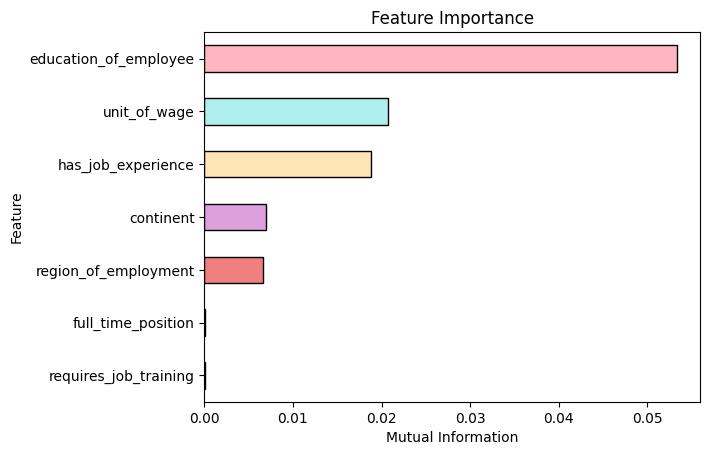

In [25]:
# Plot the bar graph
plt.title("Feature Importance")

mi.nlargest(20).plot(kind='barh', ec='black', color=['lightpink', 'paleturquoise', 'moccasin', 'plum', 'lightcoral', 'sandybrown']).invert_yaxis()
plt.xlabel("Mutual Information")
plt.ylabel('Feature')

plt.show()

**Observations:** 
* Based on MI scores, the top 5 categorical features are:
    1. `education_of_employee` (0.053302)
    2. `unit_of_wage` (0.020692)
    3. `has_job_experience` (0.018769)
    4. `continent` (0.007012)
    5. `region_of_employment` (0.006578)
* Both features, `full_time_position` and `requires_job_training`, have very low MI scores (0.000134 and 0.000040, respectively), indicating limited predictive power.
* The extremely low MI score for `requires_job_training` reinforces our earlier finding from the Chi-Square Test of Independence, confirming no significant association with case status.

#### Correlation Coefficient

The Pearson correlation coefficient measures the linear relationship between two continuous variables. It can be used to assess the strength and direction of the linear relationship between numerical features and the binary target variable.

In [26]:
df_full_train[numerical].corrwith(df_full_train.case_status)

no_of_employees    0.010961
yr_of_estab        0.008774
prevailing_wage    0.078885
dtype: float64

Based on the correlation coefficient score of 0.075117 for `prevailing_wage`, we can infer a weak positive correlation between prevailing wage and the likelihood of visa certification by the OFLC.

In [27]:
# Rank the importance of each numerical features
corr_scores_abs = df_full_train[numerical].corrwith(df_full_train.case_status).abs().sort_values(ascending=False)
corr_scores_abs

prevailing_wage    0.078885
no_of_employees    0.010961
yr_of_estab        0.008774
dtype: float64

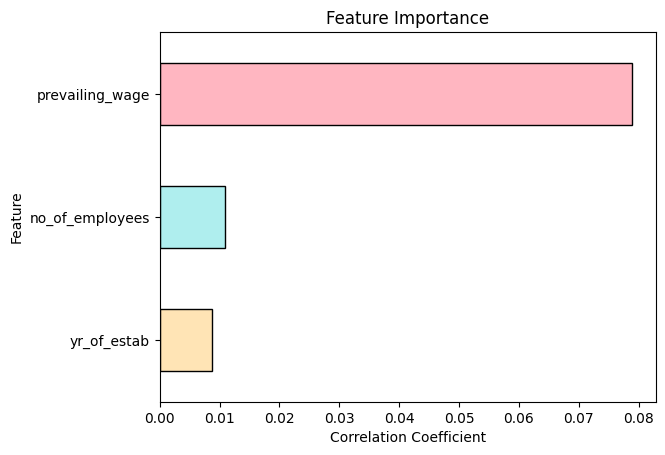

In [28]:
# Plot the bar graph
plt.title("Feature Importance")

corr_scores_abs.nlargest(20).plot(kind='barh', ec='black', color=['lightpink', 'paleturquoise', 'moccasin']).invert_yaxis()
plt.xlabel("Correlation Coefficient")
plt.ylabel('Feature')

plt.show()

**Observations:** 
* `prevailing_wage` is the most important numerical feature for predicting visa approval, followed by `yr_of_estab` and `no_of_employees`.

### Baseline Model

In [29]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [30]:
numerical

Index(['no_of_employees', 'yr_of_estab', 'prevailing_wage'], dtype='object')

In [31]:
categorical

Index(['continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'region_of_employment', 'unit_of_wage',
       'full_time_position'],
      dtype='object')

In [32]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[list(categorical) + list(numerical)].to_dict(orient='records')
X_train_baseline = dv.fit_transform(train_dict)

val_dict = df_val[list(categorical) + list(numerical)].to_dict(orient='records')
X_val_baseline = dv.transform(val_dict)

model = LogisticRegression()
model.fit(X_train_baseline, y_train)

y_pred = model.predict_proba(X_val_baseline)[:, 1]
approval_outcome = (y_pred >= 0.5)
(y_val == approval_outcome).mean()

0.7328484371928445

Our baseline logistic regression model achieved an accuracy of 73.3%.

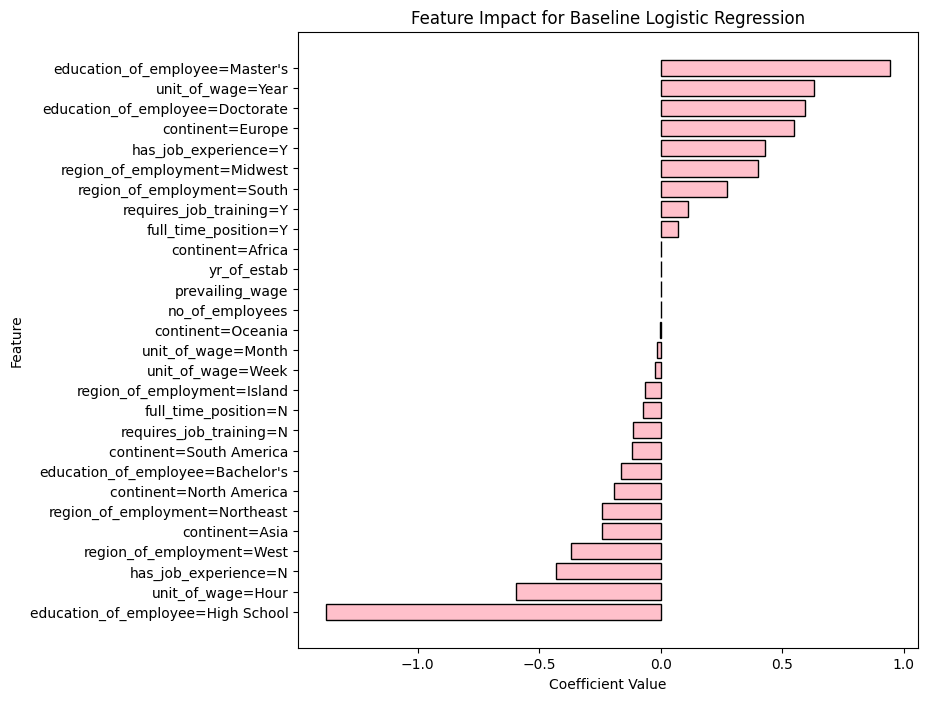

In [33]:
# Derive coefficients
coefficients = model.coef_[0]
feature_names = dv.get_feature_names_out()
indices = np.argsort(coefficients)

# Plot coefficients
plt.figure(figsize=(8, 8))

plt.title("Feature Impact for Baseline Logistic Regression")
plt.barh(range(len(indices)), coefficients[indices], color='pink', edgecolor='black', align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=10)
plt.xlabel("Coefficient Value")
plt.ylabel('Feature')

plt.show()

We analyzed the baseline logistic regression model to pinpoint the critical factors influencing case status. The coefficients tell us the importance of each feature, where higher absolute values signify greater influence, and lower absolute values indicate lesser impact.

In [34]:
thresholds = np.linspace(0, 1, 21)
scores = []

for t in thresholds:
    approval_outcome = (y_pred >= t)
    score = (y_val == approval_outcome).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.666
0.05 0.666
0.10 0.668
0.15 0.672
0.20 0.686
0.25 0.689
0.30 0.694
0.35 0.703
0.40 0.711
0.45 0.725
0.50 0.733
0.55 0.737
0.60 0.731
0.65 0.695
0.70 0.664
0.75 0.657
0.80 0.594
0.85 0.507
0.90 0.438
0.95 0.340
1.00 0.334


Text(0.5, 0, 'Threshold')

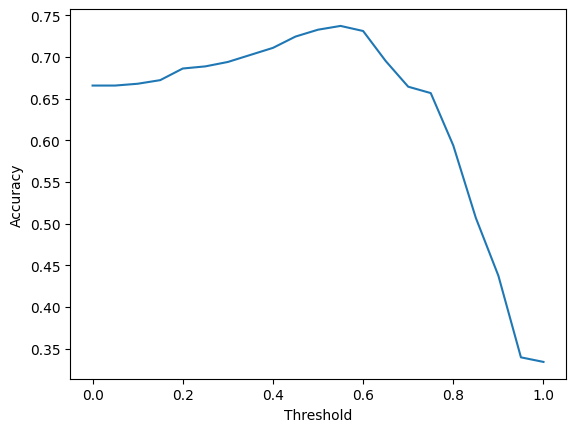

In [35]:
# Create a plot that shows how accuracy changes depending on the threshold
plt.plot(thresholds, scores)
plt.ylabel('Accuracy')
plt.xlabel('Threshold')

In [36]:
approval_outcome = (y_pred >= 0.56)
score = (y_val == approval_outcome).mean()
score

0.7379595046196187

Through experimentation with various thresholds between 0 and 1, we determined that a threshold of 0.56 yielded the highest accuracy (73.8%) for our logistic regression model on this specific dataset.

### Dummy Model

In [37]:
from collections import Counter

In [38]:
len(y_val)

5087

In [39]:
# Count # of Certified & Denied values in validation set
Counter(y_val)

Counter({1: 3387, 0: 1700})

In [40]:
y_val.mean()

0.6658148220955377

In [41]:
1 - y_val.mean()

0.33418517790446234

**Observations:**
* The baseline logistic regression model achieved an accuracy of 73.3%, which is only a slight improvement of ~7% over a simple dummy model that always predicts "Certified." 
* This limited gain suggests the model may not effectively capture underlying patterns in the data.
* Notably, the dataset exhibits class imbalance, with approximately 67% of applications certified and 33% denied.
* In such cases, accuracy alone can be misleading, as a model predicting only the majority class ("Certified") would achieve good accuracy without necessarily learning meaningful relationships.

### Baseline Model Performance

In [42]:
# Split the target variable y in validation set into certified and denied
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [43]:
# Split the predictions on validation set into certified and denied
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [44]:
# Combine prediction and actual into one and count how many of them
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

#### Confusion Matrix

In [45]:
# Create a confusion matrix
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[ 739,  961],
       [ 398, 2989]])

In [46]:
# Instead of absolute numbers, we can have percentages
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.15, 0.19],
       [0.08, 0.59]])

We encounter two types of errors, with false positives being more challenging to detect.

##### Model Misclassifications
- **False Positives:** The model incorrectly predicts that an application will be certified when it should be denied.
  - This may result in unqualified individuals securing positions that could have been filled by qualified U.S. citizens, potentially contributing to job displacement.
- **False Negatives:** The model incorrectly predicts that an application will be denied when it should be certified.
  - This can lead to the rejection of skilled foreign workers, limiting economic growth and depriving the U.S. of valuable expertise.

##### Why Minimizing Misclassifications Matters
Both types of misclassification have significant real-world implications:
- False Positives may create unfair competition for U.S. workers and introduce potential security concerns.
- False Negatives can result in the loss of skilled labor, negatively impacting industries that rely on specialized talent.

##### Improving Model Performance
- The F1-score is a key metric for evaluating model effectiveness, as it balances precision (reducing false positives) and recall (reducing false negatives).
- A higher F1-score indicates a better trade-off between the two, resulting in a more reliable classification system.

#### Accuracy

In [47]:
# Calculate accuracy
acc = (tp + tn) / (tp + tn + fp + fn)
acc

0.7328484371928445

#### Precision

In [48]:
# Calculate precision
p = tp / (tp + fp)
p

0.7567088607594936

In [49]:
# Calculate False Discovery Rate (FDR)
1 - p

0.24329113924050638

$$1 - p = \frac{FP}{TP + FP} = FDR$$

Approximately 24% of the model's predicted positives are false positives. This metric, known as the False Discovery Rate (FDR), represents the proportion of incorrect positive predictions. In other words, the model misclassifies 24% of applications as certified when they should have been denied.

#### Recall

In [50]:
# Calculate recall
r = tp / (tp + fn)
r

0.8824918807204015

In [51]:
# Calculate False Negative Rate (FNR)
1 - r

0.11750811927959848

$$1 - r = \frac{FN}{TP + FN} = FNR$$

Our model correctly identifies most actual positives, missing only approximately 12% of applications that should have been certified. This metric, known as the False Negative Rate (FNR) or Miss Rate, measures the proportion of actual positives that were incorrectly classified as negatives.

#### F1 score

In [52]:
# Calculate f1 score
f1_score = 2 * p * r / (p + r)
f1_score

0.8147744309663351

An F1-score of 0.81 suggests that the model effectively balances false positives and false negatives, though some misclassifications remain. In the context of visa approval, optimizing for both precision and recall is essential, with a stronger emphasis on high recall to avoid rejecting qualified applicants and disrupting industries that rely on specialized talent. False positives can be addressed through manual review, making them less problematic compared to the risks associated with false negatives.

#### ROC curve

In [53]:
from sklearn.metrics import roc_curve

In [54]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

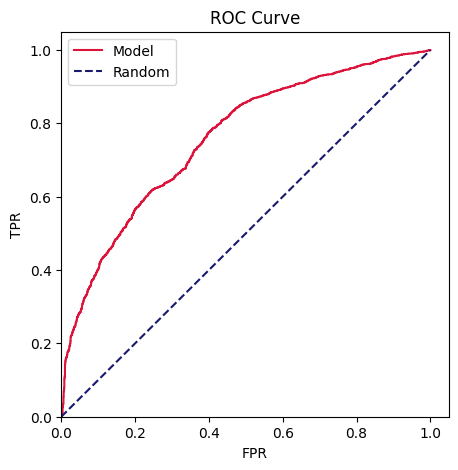

In [55]:
# Plot the ROC curve
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model', color='crimson')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--', color='midnightblue')
plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0)

plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()
plt.show()

The Receiver Operating Characteristic (ROC) curve visualizes how a model's performance changes as the classification threshold varies. At very high thresholds, all models tend to predict "Denied," leading to low True Positive Rates (TPR) and low False Positive Rates (FPR).

Good models exhibit a steep initial increase in TPR with minimal increase in FPR as the threshold decreases. This indicates a strong ability to correctly classify true positives while minimizing false positives. The ROC curve of a good model typically ascends sharply towards the top-left corner of the plot.

On the other hand, poor models demonstrate a rapid increase in FPR alongside TPR, indicating a higher rate of false positive predictions. The ROC curve of a poor model tends to have a shallower slope and may curve towards the right sooner.

#### AUROC

In [56]:
from sklearn.metrics import roc_auc_score

In [57]:
# Calculate AUROC
auroc = roc_auc_score(y_val, y_pred)
auroc

0.7578002396707133

The baseline model achieves an AUROC of 0.7578, indicating moderate discriminatory power. While the model performs better than random guessing (AUROC = 0.5), its ability to reliably distinguish between positive and negative instances remains suboptimal, suggesting room for improvement through feature engineering, resampling techniques, or hyperparameter tuning.

#### PR curve

In [58]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [59]:
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

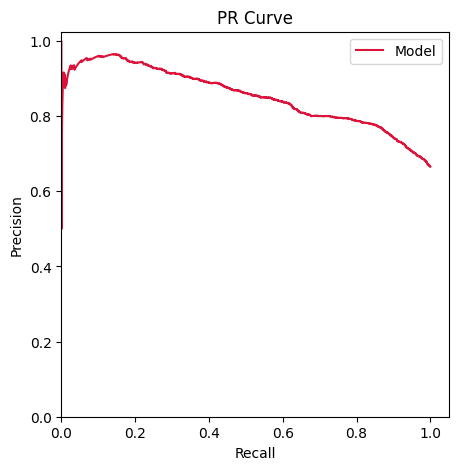

In [60]:
# Plot the PR curve
plt.figure(figsize=(5, 5))

plt.plot(recall, precision, label='Model', color='crimson')
plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0)

plt.title('PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()

A Precision-Recall (PR) curve illustrates the trade-off between precision and recall for our baseline logistic regression model across different classification thresholds.

#### AUPRC

In [61]:
# Calculate AUPRC
auprc = average_precision_score(y_val, y_pred)
auprc

0.8539331481681338

Unlike accuracy, which can be misleading in imbalanced datasets, the Area Under the Precision-Recall Curve (AUPRC) offers a more reliable evaluation by emphasizing the model's effectiveness in identifying the positive class (certified visa applications), even when it is underrepresented.

AUPRC directly integrates precision and recall, two critical metrics that measure the model’s ability to correctly identify true positives while minimizing false positives and false negatives.

An AUPRC of 0.8539 indicates strong overall performance in distinguishing certified visa applications, suggesting that the model maintains a well-balanced trade-off between precision and recall, effectively reducing misclassifications.

In [62]:
# Calculate the fraction of positives: positive examples / total number of examples
auprc_baseline = dict(Counter(y_val))[1] / len(y_val)
auprc_baseline

0.6658148220955377

The baseline AUPRC for a given class is equivalent to the proportion of positive examples in the dataset. In this case, with 66.58% of examples classified as positive, the baseline AUPRC is 0.6658.

Achieving an AUPRC of 0.8539 represents a substantial improvement over the baseline, demonstrating the model’s strong capability in correctly identifying true positives (certified visa applications) while maintaining a strong balance between precision and recall.

The higher AUPRC (0.8539) compared to AUROC (0.7578) suggests that the baseline logistic regression model excels at recognizing true positives while keeping false positives in check. This distinction is particularly important in visa approval prediction, where minimizing false positives (incorrectly certifying applications) is essential to uphold the integrity of the approval process while ensuring qualified candidates are not overlooked.

#### Recursive Feature Elimination

In [63]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [64]:
cv = StratifiedKFold(10)

# Create an RFE object with cross-validation and F1-score as scoring metric
rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='f1') 

# Fit RFE to the training data
rfecv.fit(X_train_baseline, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 5


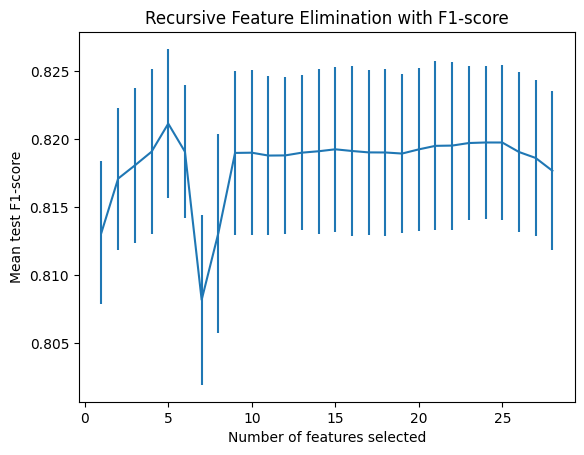

In [65]:
# Visualize the results
cv_results = pd.DataFrame(rfecv.cv_results_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test F1-score")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination with F1-score")
plt.show()

In [66]:
# Retrieve feature names
feature_names = list(dv.get_feature_names_out())

# Get feature rankings
feature_rankings = rfecv.ranking_ 

# Create a DataFrame sorted by rank
feature_importance_df = pd.DataFrame({'Feature': feature_names, 
                                      'Rank': feature_rankings}).sort_values(by='Rank').reset_index(drop=True)

# Show the feature rankings
feature_importance_df

,Feature,Rank
0,unit_of_wage=Hour,1
1,has_job_experience=N,1
2,education_of_employee=Master's,1
3,education_of_employee=Doctorate,1
4,education_of_employee=High School,1
5,continent=Europe,2
6,region_of_employment=Midwest,3
7,region_of_employment=South,4
8,unit_of_wage=Year,5
9,has_job_experience=Y,6


We conducted a preliminary feature importance analysis using Recursive Feature Elimination with Cross-Validation (RFECV) on a baseline logistic regression model. The RFECV rankings provided key insights into the most predictive features influencing visa approval outcomes.

**Key Findings:**
- Features such as `unit_of_wage=Hour`, `has_job_experience=N`, `education_of_employee=Master's`, `education_of_employee=Doctorate`, and `education_of_employee=High School` consistently ranked among the most important, indicating their strong predictive value in visa approval decisions.

- Employee qualifications (e.g., education level, job experience) and job characteristics (full-time position, job training requirements) exhibited higher predictive power than numerical features such as `yr_of_estab`, `prevailing_wage`, and `no_of_employees`. This suggests that factors related to education, job experience, and employment type play a more significant role in the visa approval process.

- The relatively high ranking of `has_job_experience=N` and `full_time_position=N` suggests that applicants without prior job experience or those seeking part-time positions may face challenges in obtaining visa approval.

**Implications:**
- The RFECV results can guide feature selection, allowing models to focus on the most predictive features, improving accuracy while reducing complexity.
- A deeper investigation into the relationship between high-ranking features and visa outcomes can provide actionable insights into the approval process.
- These findings could inform visa approval policies, highlighting key applicant attributes that influence decisions and identifying potential areas for process improvement.

**Limitations:**
- Feature importance rankings are specific to the baseline logistic regression model and may change with different models or datasets.
- High-ranking features indicate predictive power, but this does not imply a causal relationship with visa approval outcomes.
- Feature importance may shift due to changes in immigration policies, labor market conditions, or other external factors.

**Possible Next Steps:**
- Use insights from this analysis to refine feature engineering and improve model performance.
- Conduct further analysis to better understand the impact of education, job experience, and geographic factors on visa approvals.
- Combine machine learning insights with domain expertise (e.g., immigration policies, labor market trends) for a more holistic understanding of the visa approval process.

### Feature Extraction

#### Calculate company age (as of 2016)

Calculate the age of the company in years by subtracting the `yr_of_estab` from 2016.

In [67]:
year = 2016
# Add a new column for company age
df_train['company_age'] = year - df_train['yr_of_estab']
df_val['company_age'] = year - df_val['yr_of_estab']

# Remove the year of establishment column
del df_train['yr_of_estab']
del df_val['yr_of_estab']

In [68]:
df_train.head().T

,0,1,2,3,4
continent,Asia,Asia,Asia,Asia,Asia
education_of_employee,Bachelor's,Bachelor's,Master's,Bachelor's,Master's
has_job_experience,N,N,N,Y,N
requires_job_training,N,N,N,N,N
no_of_employees,2500,1527,5380,3035,546
region_of_employment,Northeast,South,West,West,South
prevailing_wage,105.87,38764.07,37037.67,89891.32,149133.36
unit_of_wage,Hour,Year,Year,Year,Year
full_time_position,Y,Y,Y,N,Y
company_age,45,3,18,109,2


In [69]:
numerical = df_train.select_dtypes(exclude="object").columns
categorical = df_train.select_dtypes(include="object").columns

In [70]:
numerical

Index(['no_of_employees', 'prevailing_wage', 'company_age'], dtype='object')

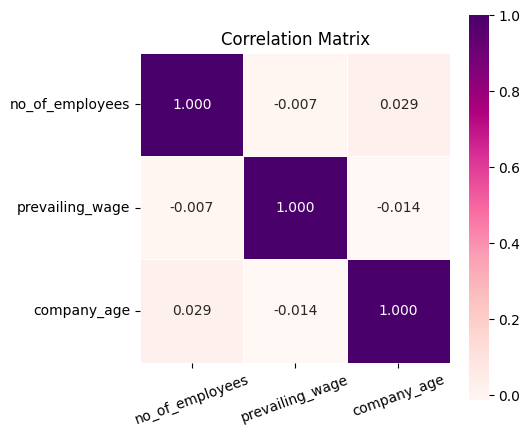

In [71]:
# Compute and plot the correlation coefficient between every pair of features
corr_matrix = df_train[numerical].corr()
plt.figure(figsize=(5, 5))

# Plot the heatmap for correlation matrix
cm = sns.heatmap(corr_matrix, annot=True, cmap='RdPu', fmt='.3f', linewidths=0.5, square=True)
plt.title('Correlation Matrix')
plt.xticks(rotation=20)
plt.yticks(rotation=0)

plt.show()

**Insights:**
- The correlation matrix reveals minimal linear relationships among the numerical features (`no_of_employees`, `prevailing_wage`, and `company_age`), with correlation coefficients close to zero, suggesting a lack of direct linear dependence.
- These low correlations indicate that the features are largely independent, reducing the risk of redundancy in the model.
- The absence of strong correlations suggests that multicollinearity is unlikely to be a concern, ensuring that individual feature contributions remain interpretable in linear models.
- Given these weak associations, creating interaction terms between these features is unlikely to yield significant improvements in predictive performance. However, further non-linear transformations or higher-order interactions may still warrant exploration.

### Feature Transformation

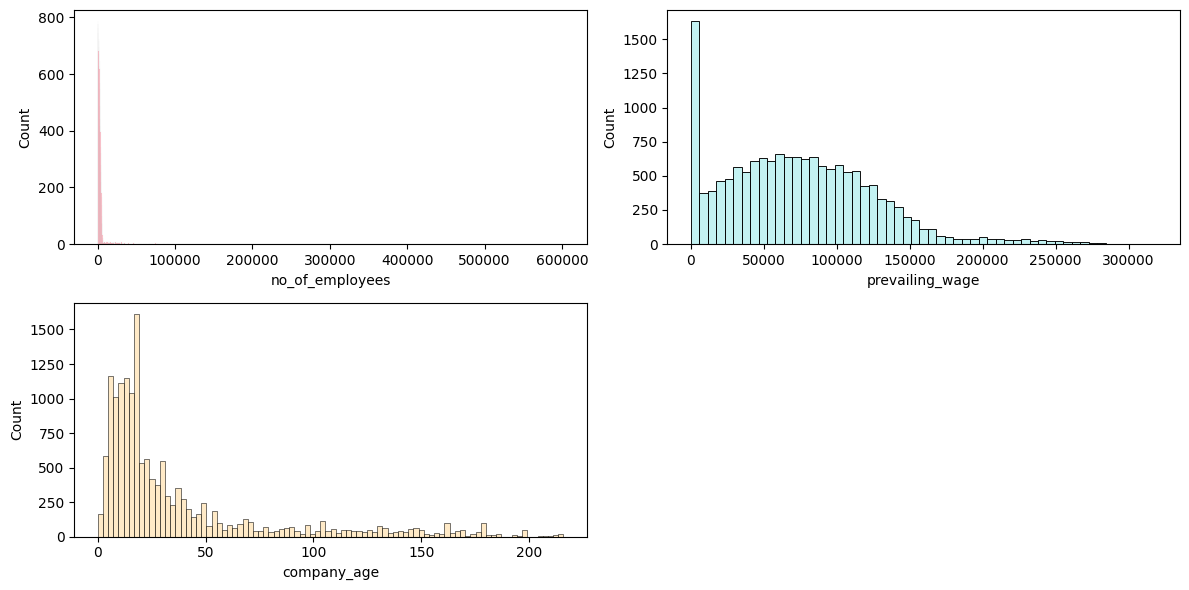

In [72]:
# Plot distribution of numerical features before scaling
plt.figure(figsize=(12, 6))

colors = ['lightpink', 'paleturquoise', 'moccasin']

for i, feature in enumerate(numerical):
    plt.subplot(2, 2, i+1)
    # Plot the histogram
    sns.histplot(x=df_train[feature], color=colors[i])
    plt.xlabel(feature)
    plt.tight_layout()

plt.show()

In [73]:
# Check Skewness
df_train[numerical].skew(axis=0)

no_of_employees    12.853625
prevailing_wage     0.777704
company_age         2.007334
dtype: float64

Highly skewed feature distributions can significantly degrade the performance of certain machine learning models. While logistic regression is more robust to non-normality than other models, it is still susceptible to the influence of skewed features. Skewness in features can disrupt the assumption of linearity between the log-odds of the outcome and the features in logistic regression. This misalignment can lead to biased predictions, especially for data points with extreme values, thus diminishing the model’s accuracy, precision, and recall. Addressing skewness often becomes critical to ensuring the stability and reliability of the model’s predictions.

**Understanding Skewness in Features:**

- `no_of_employees`: The skewness value of 12.85 indicates a strong right skew, meaning the majority of the data is concentrated toward companies with fewer employees, while a small number of companies exhibit a disproportionately high number of employees. This type of skewness can lead to outliers having an outsized influence on the model, especially if not addressed.

- `prevailing_wage`: A skewness value of 0.7777 signifies moderate right skewness. While the data is somewhat concentrated around lower wages, the distribution has a longer tail extending towards higher wages. Although less extreme than the previous example, this skewness could still cause certain models to overemphasize higher wage outliers if not properly handled.

- `company_age`: The skewness value of 2.007 reflects a moderate right skew. The distribution is predominantly concentrated around younger companies, with a longer tail toward older companies. Such skewness can affect model predictions by giving undue weight to a small number of very old companies, especially if the skew is not addressed, leading to potential bias in estimating outcomes for younger firms.

#### Experiment with Yeo-Johnson transformation

The Yeo-Johnson transformation extends the Box-Cox transformation by normalizing data that includes positive, negative, and zero values. Unlike Box-Cox, which is restricted to positive values, Yeo-Johnson applies different transformation functions based on the sign of the input, making it more versatile. This flexibility allows it to effectively reduce skewness and approximate a normal distribution for both right-skewed and left-skewed data. As a result, Yeo-Johnson serves as a valuable preprocessing technique for improving the performance of machine learning models that benefit from normally distributed features or linear relationships.

In [74]:
from sklearn.preprocessing import PowerTransformer

In [75]:
transform_features = ['no_of_employees', 'company_age']

pt = PowerTransformer(method='yeo-johnson')
X_train_transformed = pt.fit_transform(df_train[transform_features])

In [76]:
df_transformed = pd.DataFrame(X_train_transformed, columns=transform_features)

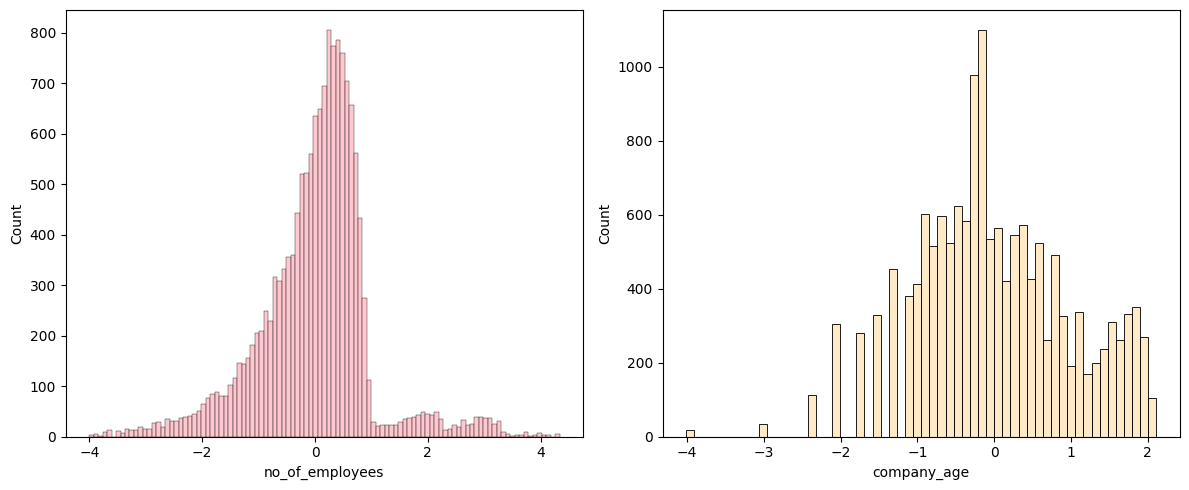

In [77]:
# Plot distribution of numerical features after scaling
plt.figure(figsize=(12, 5))

colors = ['lightpink', 'moccasin']

for i, feature in enumerate(transform_features):
    plt.subplot(1, 2, i+1)
    # Plot the histogram
    sns.histplot(x=df_transformed[feature], color=colors[i])
    plt.xlabel(feature)
    plt.tight_layout()

plt.show()

In [78]:
# Check Skewness
df_transformed.skew(axis=0)

no_of_employees   -0.023475
company_age        0.009601
dtype: float64

**Insights:**
- The Yeo-Johnson transformation effectively reduced the skewness in the two numerical features (`no_of_employees` and `company_age`). This is evident from the significantly lower skewness values after the transformation.

- By mitigating skewness, the Yeo-Johnson transformation has the potential to improve the performance of models sensitive to non-normality. This is because the transformation brings the data distribution closer to normality, which can enhance model accuracy and predictive power.

- It's crucial to remember that after the Yeo-Johnson transformation, the original interpretation of the features changes. The units of `no_of_employees` and `company_age` are no longer directly interpretable as they were before the transformation.

**Possible Next Steps:**
- Train machine learning models (e.g., logistic regression, random forest) on both the transformed and original data. Evaluate their performance using appropriate metrics (e.g., accuracy, precision, recall, F1-score, AUC) to assess the impact of the Yeo-Johnson transformation on model accuracy and identify the approach that yields the best results.

- Experiment with other data transformations, such as the Box-Cox transformation or quantile transformations, to further investigate their impact on model performance and feature interpretability.

- Explore the use of robust models that are less sensitive to non-normality, such as tree-based models (e.g., Random Forest, Gradient Boosting Machines). 

#### Encode binary categorical features

In [79]:
# Encode binary categorical features using binary encoding (0 for "N", 1 for "Y")
df_train.has_job_experience = (df_train.has_job_experience == 'Y').astype(int)
df_val.has_job_experience = (df_val.has_job_experience == 'Y').astype(int)

df_train.full_time_position = (df_train.full_time_position == 'Y').astype(int)
df_val.full_time_position = (df_val.full_time_position == 'Y').astype(int)

df_train.requires_job_training = (df_train.requires_job_training == 'Y').astype(int)
df_val.requires_job_training = (df_val.requires_job_training == 'Y').astype(int)

In [80]:
df_train.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,company_age
0,Asia,Bachelor's,0,0,2500,Northeast,105.87,Hour,1,45
1,Asia,Bachelor's,0,0,1527,South,38764.07,Year,1,3
2,Asia,Master's,0,0,5380,West,37037.67,Year,1,18
3,Asia,Bachelor's,1,0,3035,West,89891.32,Year,0,109
4,Asia,Master's,0,0,546,South,149133.36,Year,1,2


#### Feature encoding and scaling

In [81]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [82]:
# Create ColumnTransformer with 2 types of transformers
oh_columns = ['continent', 'unit_of_wage', 'region_of_employment', 'education_of_employee']
transform_columns= ['no_of_employees', 'company_age']
numeric_columns = ['prevailing_wage']

# Initialize OneHotEncoder for categorical columns
oh_transformer = OneHotEncoder()

# Create a pipeline for PowerTransformer
transform_pipeline = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

# Transform numerical data to have a mean of 0 and a standard deviation of 1
numeric_transformer = StandardScaler()

# Combine all transformers using ColumnTransformer
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('OneHotEncoder', oh_transformer, oh_columns),
        ('Transformer', transform_pipeline, transform_columns),
        ('StandardScaler', numeric_transformer, numeric_columns)
    ],
    remainder='passthrough'
)

In [83]:
X_train_scaled = preprocessor_scaled.fit_transform(df_train)
X_train_scaled[0]

array([ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.24627662,
        0.74036002, -1.40813909,  0.        ,  0.        ,  1.        ])

In [84]:
X_train_scaled.shape

(15261, 25)

In [85]:
preprocessor_scaled.get_feature_names_out()

array(['OneHotEncoder__continent_Africa', 'OneHotEncoder__continent_Asia',
       'OneHotEncoder__continent_Europe',
       'OneHotEncoder__continent_North America',
       'OneHotEncoder__continent_Oceania',
       'OneHotEncoder__continent_South America',
       'OneHotEncoder__unit_of_wage_Hour',
       'OneHotEncoder__unit_of_wage_Month',
       'OneHotEncoder__unit_of_wage_Week',
       'OneHotEncoder__unit_of_wage_Year',
       'OneHotEncoder__region_of_employment_Island',
       'OneHotEncoder__region_of_employment_Midwest',
       'OneHotEncoder__region_of_employment_Northeast',
       'OneHotEncoder__region_of_employment_South',
       'OneHotEncoder__region_of_employment_West',
       "OneHotEncoder__education_of_employee_Bachelor's",
       'OneHotEncoder__education_of_employee_Doctorate',
       'OneHotEncoder__education_of_employee_High School',
       "OneHotEncoder__education_of_employee_Master's",
       'Transformer__no_of_employees', 'Transformer__company_age',
      

In [86]:
df_train.head(1)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,company_age
0,Asia,Bachelor's,0,0,2500,Northeast,105.87,Hour,1,45


In [87]:
X_val_scaled = preprocessor_scaled.transform(df_val)
X_val_scaled[0]

array([ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        , -0.69254934,
        1.70137852, -0.48190652,  0.        ,  0.        ,  1.        ])

In [88]:
X_val_scaled.shape

(5087, 25)

In [89]:
# Create ColumnTransformer for Tree-based models
preprocessor = ColumnTransformer(
    transformers=[
        ('OneHotEncoder', oh_transformer, oh_columns),
    ],
    remainder='passthrough'
)

In [90]:
X_train = preprocessor.fit_transform(df_train)
X_train[0]

array([0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 2.5000e+03, 1.0587e+02, 1.0000e+00, 4.5000e+01])

In [91]:
preprocessor.get_feature_names_out()

array(['OneHotEncoder__continent_Africa', 'OneHotEncoder__continent_Asia',
       'OneHotEncoder__continent_Europe',
       'OneHotEncoder__continent_North America',
       'OneHotEncoder__continent_Oceania',
       'OneHotEncoder__continent_South America',
       'OneHotEncoder__unit_of_wage_Hour',
       'OneHotEncoder__unit_of_wage_Month',
       'OneHotEncoder__unit_of_wage_Week',
       'OneHotEncoder__unit_of_wage_Year',
       'OneHotEncoder__region_of_employment_Island',
       'OneHotEncoder__region_of_employment_Midwest',
       'OneHotEncoder__region_of_employment_Northeast',
       'OneHotEncoder__region_of_employment_South',
       'OneHotEncoder__region_of_employment_West',
       "OneHotEncoder__education_of_employee_Bachelor's",
       'OneHotEncoder__education_of_employee_Doctorate',
       'OneHotEncoder__education_of_employee_High School',
       "OneHotEncoder__education_of_employee_Master's",
       'remainder__has_job_experience',
       'remainder__requires_job_t

In [92]:
X_val = preprocessor.transform(df_val)
X_val[0]

array([0.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
       1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 7.770000e+02, 4.894828e+04, 1.000000e+00,
       1.310000e+02])

## 5. Data Modeling

### Model evaluation and metrics

In [93]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, precision_score, 
                            recall_score, f1_score, roc_auc_score, average_precision_score)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

In [94]:
def evaluate_clf(y, y_pred):
    acc = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auroc = roc_auc_score(y, y_pred)
    auprc = average_precision_score(y, y_pred)
    return acc, precision, recall, f1, auroc, auprc

In [95]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Classifier': SVC(random_state=SEED),
    'K-Neighbors Classifier': KNeighborsClassifier(),
    'MLP Classifier': MLPClassifier(random_state=SEED)
}

In [96]:
tree_based_models = {
    'Random Forest': RandomForestClassifier(random_state=SEED),
    'Decision Tree': DecisionTreeClassifier(random_state=SEED),
    'Gradient Boosting': GradientBoostingClassifier(random_state=SEED),
    'AdaBoost Classifier': AdaBoostClassifier(random_state=SEED),
    'XGB Classifier': XGBClassifier(random_state=SEED),
    'CatBoosting Classifier': CatBoostClassifier(random_state=SEED, verbose=False),
    'LightGBM': LGBMClassifier(random_state=SEED, verbosity=-1)
}

In [97]:
# Evaluate a dictionary of models and return a report 
def evaluate_models(X_train, y_train, X_val, y_val, models):
    train_results = []
    val_results = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Train set performance
        (train_acc, train_precision, train_recall,
        train_f1, train_auroc, train_auprc) = evaluate_clf(y_train ,y_train_pred)

        # Validation set performance
        (val_acc, val_precision, val_recall,
        val_f1, val_auroc, val_auprc) = evaluate_clf(y_val, y_val_pred)

        # Model performance on Training set
        train_result = {
            'Model Name': list(models.keys())[i],
            'Accuracy': train_acc,
            'Precision': train_precision,
            'Recall': train_recall,
            'F1-score': train_f1,
            'AUROC': train_auroc,
            'AUPRC': train_auprc
        }
        train_results.append(train_result)

        # Model performance on Validation set
        val_result = {
            'Model Name': list(models.keys())[i],
            'Accuracy': val_acc,
            'Precision': val_precision,
            'Recall': val_recall,
            'F1-score': val_f1,
            'AUROC': val_auroc,
            'AUPRC': val_auprc
        }
        val_results.append(val_result)

    df_train_report = pd.DataFrame(train_results).sort_values(by=['Accuracy'], ascending=False)
    df_val_report = pd.DataFrame(val_results).sort_values(by=['Accuracy'], ascending=False)
    return df_train_report, df_val_report

In [98]:
def combine_report(df1, df2):
    df_merged = pd.concat([df1, df2])
    return df_merged.sort_values(by=['Accuracy'], ascending=False)

In [99]:
# Show the distribution of classes in the training target variable
Counter(y_train)

Counter({1: 10235, 0: 5026})

The training set exhibits a class imbalance, with approximately twice as many certified applications as denied applications.

In [100]:
train_report, val_report = evaluate_models(X_train=X_train_scaled, y_train=y_train,
                                                     X_val=X_val_scaled, y_val=y_val, models=models)

train_report_tree, val_report_tree = evaluate_models(X_train=X_train, y_train=y_train,
                                                     X_val=X_val, y_val=y_val, models=tree_based_models)

# Combine the performance report of all models into one dataframe
train_perf_report = combine_report(train_report, train_report_tree)
val_perf_report = combine_report(val_report, val_report_tree)

##### Check model performance on train set

In [101]:
train_perf_report

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
0,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,XGB Classifier,0.850993,0.853539,0.938935,0.894203,0.805421,0.842372
5,CatBoosting Classifier,0.798375,0.812086,0.909917,0.858222,0.740573,0.799346
2,K-Neighbors Classifier,0.797392,0.821844,0.891060,0.855053,0.748853,0.805374
6,LightGBM,0.786449,0.803992,0.901319,0.849878,0.726923,0.790835
3,MLP Classifier,0.776555,0.808963,0.872985,0.839756,0.726584,0.791397
1,Support Vector Classifier,0.759452,0.782153,0.888911,0.832121,0.692366,0.769767
2,Gradient Boosting,0.758797,0.784659,0.882560,0.830735,0.694662,0.771272
0,Logistic Regression,0.741301,0.768285,0.879531,0.820153,0.669670,0.756525


##### Check model performance on validation set

In [102]:
val_perf_report

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
2,Gradient Boosting,0.748771,0.776119,0.875111,0.822648,0.686085,0.762344
6,LightGBM,0.748378,0.776002,0.874520,0.822321,0.685790,0.762176
5,CatBoosting Classifier,0.747788,0.775105,0.875111,0.822077,0.684614,0.761455
1,Support Vector Classifier,0.746019,0.771022,0.879835,0.821842,0.679623,0.758380
3,MLP Classifier,0.735797,0.779022,0.842043,0.809308,0.683080,0.761140
0,Logistic Regression,0.735207,0.761270,0.877473,0.815252,0.664619,0.749575
3,AdaBoost Classifier,0.730686,0.753583,0.884854,0.813960,0.654192,0.743477
4,XGB Classifier,0.730489,0.765543,0.857986,0.809133,0.667229,0.751380
0,Random Forest,0.719874,0.763568,0.839091,0.799550,0.660722,0.747839
2,K-Neighbors Classifier,0.708866,0.753998,0.835252,0.792548,0.646156,0.739470


#### Hyperparameter Tuning

Based on our model evaluation report, *Gradient Boosting*, *LightGBM*, and *CatBoosting Classifier* emerged as the top-3 best performing models. We will now proceed with hyperparameter tuning for these models to potentially enhance their predictive accuracy. 

In [103]:
from sklearn.model_selection import RandomizedSearchCV

In [104]:
# Initialize parameters for Hyperparameter Tuning
gb_params = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'subsample': [0.7, 0.75, 0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

lgbm_params = {
    'num_leaves': [20, 31, 40, 50],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [-1, 5, 10, 15],
    'min_child_samples': [10, 20, 30, 50],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1],
    'n_estimators': [100, 500, 1000]
}

cb_params = {
    'iterations': [300, 500, 1000, 1500],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bylevel': [0.7, 0.8, 1.0]
}

models_grid = [
    ('Gradient Boosting', GradientBoostingClassifier(random_state=SEED), gb_params),
    ('LightGBM', LGBMClassifier(random_state=SEED, verbosity=-1), lgbm_params),
    ('CatBoosting Classifier', CatBoostClassifier(random_state=SEED, verbose=False), cb_params)
]

In [105]:
models_param = {}
for name, model, params in models_grid:
    random_obj = RandomizedSearchCV(estimator=model,
                                    param_distributions=params,
                                    n_iter=100,
                                    cv=3,
                                    verbose=2, 
                                    n_jobs=-1)
    
    random_obj.fit(X_train, y_train)
    models_param[name] = random_obj.best_params_

for model_name in models_param:
    print(f'\nBest parameters for {model_name}:')
    print(models_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best parameters for Gradient Boosting:
{'subsample': 1.0, 'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5, 'learning_rate': 0.01}

Best parameters for LightGBM:
{'reg_lambda': 1, 'reg_alpha': 0.5, 'num_leaves': 20, 'n_estimators': 100, 'min_child_samples': 20, 'max_depth': 10, 'learning_rate': 0.05}

Best parameters for CatBoosting Classifier:
{'subsample': 0.7, 'learning_rate': 0.03, 'l2_leaf_reg': 5, 'iterations': 300, 'depth': 6, 'colsample_bylevel': 0.7}


In [106]:
selected_models = {
    'Gradient Boosting': GradientBoostingClassifier(**models_param['Gradient Boosting'], random_state=SEED),
    'LightGBM': LGBMClassifier(**models_param['LightGBM'], random_state=SEED, verbosity=-1),
    'CatBoosting Classifier': CatBoostClassifier(**models_param['CatBoosting Classifier'], random_state=SEED, verbose=False),
}

tuned_train_perf_report, tuned_val_perf_report = evaluate_models(X_train=X_train, y_train=y_train,
                                                                 X_val=X_val, y_val=y_val, 
                                                                 models=selected_models)

##### Check model performance on train set

In [107]:
tuned_train_perf_report

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
0,Gradient Boosting,0.771771,0.796036,0.886957,0.839041,0.712082,0.781864
2,CatBoosting Classifier,0.764236,0.788189,0.886761,0.834575,0.700742,0.774881
1,LightGBM,0.760435,0.787921,0.879531,0.831210,0.698719,0.773795


##### Check model performance on validation set

In [108]:
tuned_val_perf_report

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
0,Gradient Boosting,0.749361,0.778922,0.870682,0.822250,0.689165,0.764296
2,CatBoosting Classifier,0.748771,0.775830,0.875701,0.822746,0.685792,0.762156
1,LightGBM,0.748575,0.776931,0.873044,0.822188,0.686816,0.762824


Among the tuned models, Gradient Boosting Classifier showed the most promising results with minimal performance difference between the training and validation. 

#### Experiment with SMOTE

In [109]:
from imblearn.over_sampling import SMOTE

In [110]:
smt = SMOTE(random_state=SEED)
X_train_scaled_sm, y_train_scaled_sm = smt.fit_resample(X_train_scaled, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

In [111]:
# Show the distribution of classes in the training target variable
Counter(y_train_sm)

Counter({1: 10235, 0: 10235})

The training set has been balanced using SMOTE, ensuring an equal number of samples for both classes: Certified and Denied.

In [112]:
train_report_sm, val_report_sm = evaluate_models(X_train=X_train_scaled_sm, y_train=y_train_scaled_sm,
                                                 X_val=X_val_scaled, y_val=y_val,
                                                 models=models)

train_report_tree_sm, val_report_tree_sm = evaluate_models(X_train=X_train_sm, y_train=y_train_sm,
                                                           X_val=X_val, y_val=y_val,
                                                           models=tree_based_models)

# Combine the performance report of all models into one dataframe
train_perf_report_sm = combine_report(train_report_sm, train_report_tree_sm)
val_perf_report_sm = combine_report(val_report_sm, val_report_tree_sm)

##### Check model performance on train set

In [113]:
train_perf_report_sm

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
0,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,XGB Classifier,0.882267,0.850425,0.927699,0.887383,0.882267,0.825089
5,CatBoosting Classifier,0.852858,0.820083,0.904055,0.860024,0.852858,0.789373
2,K-Neighbors Classifier,0.836541,0.889693,0.768344,0.824578,0.836541,0.799419
6,LightGBM,0.835515,0.801281,0.892330,0.844358,0.835515,0.768842
2,Gradient Boosting,0.815633,0.788257,0.863117,0.823990,0.815633,0.748800
3,AdaBoost Classifier,0.805227,0.775339,0.859502,0.815254,0.805227,0.736655
3,MLP Classifier,0.773034,0.773140,0.772838,0.772989,0.773034,0.711093
1,Support Vector Classifier,0.739961,0.726401,0.769907,0.747522,0.739961,0.674308


##### Check model performance on validation set

In [114]:
val_perf_report_sm

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
5,CatBoosting Classifier,0.747788,0.779787,0.865663,0.820484,0.689302,0.764477
6,LightGBM,0.746609,0.777220,0.868320,0.820248,0.686219,0.762550
2,Gradient Boosting,0.746019,0.783032,0.855624,0.817720,0.691636,0.766108
3,AdaBoost Classifier,0.737370,0.773540,0.856215,0.812780,0.678402,0.758050
4,XGB Classifier,0.735404,0.772497,0.854148,0.811273,0.676486,0.756937
1,Support Vector Classifier,0.722037,0.814472,0.754355,0.783262,0.706001,0.777955
0,Random Forest,0.720464,0.764611,0.838205,0.799718,0.662044,0.748626
3,MLP Classifier,0.703755,0.808804,0.726897,0.765666,0.692272,0.769753
0,Logistic Regression,0.697071,0.815448,0.704458,0.755901,0.693406,0.771225
2,K-Neighbors Classifier,0.662866,0.790479,0.671686,0.726257,0.658490,0.749550


##### Perform Hyperparameter Tuning

In [115]:
models_param_sm = {}
for name, model, params in models_grid:
    random_obj = RandomizedSearchCV(estimator=model,
                                    param_distributions=params,
                                    n_iter=100,
                                    cv=3,
                                    verbose=2,
                                    n_jobs=-1)
    
    random_obj.fit(X_train_sm, y_train_sm)
    models_param_sm[name] = random_obj.best_params_

for model_name in models_param_sm:
    print(f'\nBest parameters for {model_name}:')
    print(models_param_sm[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best parameters for Gradient Boosting:
{'subsample': 0.75, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 7, 'learning_rate': 0.01}

Best parameters for LightGBM:
{'reg_lambda': 0.1, 'reg_alpha': 1, 'num_leaves': 50, 'n_estimators': 500, 'min_child_samples': 20, 'max_depth': 15, 'learning_rate': 0.01}

Best parameters for CatBoosting Classifier:
{'subsample': 0.8, 'learning_rate': 0.03, 'l2_leaf_reg': 5, 'iterations': 300, 'depth': 8, 'colsample_bylevel': 0.8}


In [116]:
selected_models = {
    'Gradient Boosting': GradientBoostingClassifier(**models_param_sm['Gradient Boosting'], random_state=SEED),
    'LightGBM': LGBMClassifier(**models_param_sm['LightGBM'], random_state=SEED, verbosity=-1),
    'CatBoosting Classifier': CatBoostClassifier(**models_param_sm['CatBoosting Classifier'], random_state=SEED, verbose=False),
}

tuned_train_perf_report_sm, tuned_val_perf_report_sm = evaluate_models(X_train=X_train_sm, y_train=y_train_sm,
                                                                       X_val=X_val, y_val=y_val, 
                                                                       models=selected_models)

##### Check model performance on train set

In [117]:
tuned_train_perf_report_sm

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
2,CatBoosting Classifier,0.829360,0.798055,0.881876,0.837874,0.829360,0.762847
1,LightGBM,0.828578,0.796300,0.883048,0.837433,0.828578,0.761647
0,Gradient Boosting,0.812946,0.782252,0.867318,0.822592,0.812946,0.744803


##### Check model performance on validation set

In [118]:
tuned_val_perf_report_sm

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
2,CatBoosting Classifier,0.750737,0.782157,0.867139,0.822459,0.692981,0.766700
0,Gradient Boosting,0.747592,0.781375,0.862120,0.819764,0.690766,0.765442
1,LightGBM,0.747592,0.780027,0.864777,0.820218,0.689447,0.764583


#### Experiment with ADASYN

In [119]:
from imblearn.over_sampling import ADASYN

In [120]:
ada = ADASYN(random_state=SEED)
X_train_scaled_ada, y_train_scaled_ada = ada.fit_resample(X_train_scaled, y_train)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

In [121]:
# Show the distribution of classes in the training target variable
Counter(y_train_ada)

Counter({0: 10268, 1: 10235})

After applying ADASYN, the number of samples in each class is now nearly equal (10,390 Denied vs. 10,235 Certified). This demonstrates that the class imbalance has been effectively mitigated, though the distribution is not perfectly balanced.

In [122]:
train_report_ada, val_report_ada = evaluate_models(X_train=X_train_scaled_ada, y_train=y_train_scaled_ada,
                                                   X_val=X_val_scaled, y_val=y_val,
                                                   models=models)

train_report_tree_ada, val_report_tree_ada = evaluate_models(X_train=X_train_ada, y_train=y_train_ada,
                                                             X_val=X_val, y_val=y_val,
                                                             models=tree_based_models)

# Combine the performance report of all models into one dataframe
train_perf_report_ada = combine_report(train_report_ada, train_report_tree_ada)
val_perf_report_ada = combine_report(val_report_ada, val_report_tree_ada)

##### Check model performance on train set

In [123]:
train_perf_report_ada

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
0,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,XGB Classifier,0.883822,0.851113,0.929946,0.888785,0.883896,0.826460
5,CatBoosting Classifier,0.852412,0.818898,0.904348,0.859504,0.852495,0.788317
6,LightGBM,0.835878,0.801210,0.892721,0.844494,0.835969,0.768810
2,K-Neighbors Classifier,0.831116,0.931531,0.713825,0.808275,0.830814,0.807668
2,Gradient Boosting,0.815539,0.788312,0.861944,0.823485,0.815614,0.748398
3,AdaBoost Classifier,0.788860,0.763567,0.835857,0.798078,0.788936,0.720172
3,MLP Classifier,0.737806,0.712076,0.796190,0.751787,0.737957,0.668590
1,Support Vector Classifier,0.705842,0.736747,0.638202,0.683943,0.705668,0.650625


##### Check model performance on validation set

In [124]:
val_perf_report_ada

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
2,Gradient Boosting,0.747002,0.784707,0.854443,0.818092,0.693692,0.767402
5,CatBoosting Classifier,0.746609,0.779435,0.863891,0.819493,0.688416,0.763971
6,LightGBM,0.746216,0.777249,0.867434,0.819869,0.686070,0.762476
4,XGB Classifier,0.732062,0.771168,0.849720,0.808541,0.673683,0.755336
3,AdaBoost Classifier,0.719678,0.767239,0.831119,0.797902,0.664383,0.750110
0,Random Forest,0.717122,0.761969,0.836433,0.797467,0.657923,0.746241
3,MLP Classifier,0.714763,0.802311,0.758488,0.779784,0.693068,0.769346
0,Logistic Regression,0.680165,0.830827,0.652495,0.730941,0.693894,0.773484
1,Support Vector Classifier,0.673875,0.848950,0.620608,0.717039,0.700304,0.779470
1,Decision Tree,0.652644,0.740071,0.737231,0.738648,0.610674,0.720559


##### Perform Hyperparameter Tuning

In [125]:
models_param_ada = {}
for name, model, params in models_grid:
    random_obj = RandomizedSearchCV(estimator=model,
                                    param_distributions=params,
                                    n_iter=100,
                                    cv=3,
                                    verbose=2,
                                    n_jobs=-1)
    
    random_obj.fit(X_train_ada, y_train_ada)
    models_param_ada[name] = random_obj.best_params_

for model_name in models_param_ada:
    print(f'\nBest parameters for {model_name}:')
    print(models_param_ada[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best parameters for Gradient Boosting:
{'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.01}

Best parameters for LightGBM:
{'reg_lambda': 0.5, 'reg_alpha': 1, 'num_leaves': 40, 'n_estimators': 500, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.01}

Best parameters for CatBoosting Classifier:
{'subsample': 0.7, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 8, 'colsample_bylevel': 0.7}


In [126]:
selected_models = {
    'Gradient Boosting': GradientBoostingClassifier(**models_param_ada['Gradient Boosting'], random_state=SEED),
    'LightGBM': LGBMClassifier(**models_param_ada['LightGBM'], random_state=SEED, verbosity=-1),
    'CatBoosting Classifier': CatBoostClassifier(**models_param_ada['CatBoosting Classifier'], random_state=SEED, verbose=False),
}

tuned_train_perf_report_ada, tuned_val_perf_report_ada = evaluate_models(X_train=X_train_ada, y_train=y_train_ada,
                                                                         X_val=X_val, y_val=y_val,
                                                                         models=selected_models)

##### Check model performance on train set

In [127]:
tuned_train_perf_report_ada

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
2,CatBoosting Classifier,0.836561,0.804764,0.888031,0.844349,0.836643,0.770549
1,LightGBM,0.823294,0.792101,0.875916,0.831903,0.823379,0.755756
0,Gradient Boosting,0.814905,0.782803,0.870835,0.824476,0.814995,0.746171


##### Check model performance on validation set

In [128]:
tuned_val_perf_report_ada

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
0,Gradient Boosting,0.749558,0.781508,0.865958,0.821569,0.691803,0.766000
2,CatBoosting Classifier,0.748575,0.780917,0.865072,0.820843,0.690771,0.765386
1,LightGBM,0.746806,0.779792,0.863596,0.819557,0.688857,0.764245


#### Experiment with SMOTETomek

In [129]:
from imblearn.combine import SMOTETomek

In [130]:
smtom = SMOTETomek(random_state=SEED)
X_train_scaled_smtom, y_train_scaled_smtom = smtom.fit_resample(X_train_scaled, y_train)
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, y_train)

In [131]:
# Show the distribution of classes in the training target variable
Counter(y_train_smtom)

Counter({1: 8623, 0: 8623})

After applying SMOTETomek, the training set now exhibits a perfectly balanced class distribution, with 9,458 samples in each class (Denied and Certified). This effectively resolves the initial class imbalance present in `X_train` and `y_train`.

In [132]:
train_report_smtom, val_report_smtom = evaluate_models(X_train=X_train_scaled_smtom, y_train=y_train_scaled_smtom,
                                                       X_val=X_val_scaled, y_val=y_val,
                                                       models=models)

train_report_tree_smtom, val_report_tree_smtom = evaluate_models(X_train=X_train_smtom, y_train=y_train_smtom,
                                                                 X_val=X_val, y_val=y_val,
                                                                 models=tree_based_models)

# Combine the performance report of all models into one dataframe
train_perf_report_smtom = combine_report(train_report_smtom, train_report_tree_smtom)
val_perf_report_smtom = combine_report(val_report_smtom, val_report_tree_smtom)

##### Check model performance on train set

In [133]:
train_perf_report_smtom

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
0,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,XGB Classifier,0.898643,0.864335,0.945727,0.903201,0.898643,0.844561
5,CatBoosting Classifier,0.863737,0.828326,0.917662,0.870709,0.863737,0.801292
2,K-Neighbors Classifier,0.857431,0.911204,0.792048,0.847458,0.857431,0.825693
6,LightGBM,0.849240,0.811073,0.910588,0.857955,0.849240,0.783260
2,Gradient Boosting,0.825003,0.794597,0.876609,0.833591,0.825003,0.758246
3,AdaBoost Classifier,0.799084,0.774245,0.844370,0.807788,0.799084,0.731564
3,MLP Classifier,0.798108,0.804650,0.787370,0.795916,0.798108,0.739872
1,Support Vector Classifier,0.762492,0.747842,0.792048,0.769310,0.762492,0.696303


##### Check model performance on validation set

In [134]:
val_perf_report_smtom

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
2,Gradient Boosting,0.751130,0.780778,0.870682,0.823283,0.691812,0.765912
6,LightGBM,0.743660,0.769470,0.878063,0.820188,0.676973,0.756830
5,CatBoosting Classifier,0.741301,0.771002,0.869796,0.817425,0.677545,0.757307
4,XGB Classifier,0.733831,0.766309,0.863596,0.812049,0.669445,0.752601
3,AdaBoost Classifier,0.725182,0.769147,0.839091,0.802598,0.668663,0.752520
1,Support Vector Classifier,0.721840,0.814013,0.754650,0.783208,0.705560,0.777652
0,Random Forest,0.715943,0.759626,0.838795,0.797250,0.654986,0.744503
3,MLP Classifier,0.700020,0.810270,0.717449,0.761040,0.691372,0.769454
0,Logistic Regression,0.698840,0.816445,0.706525,0.757518,0.695027,0.772239
2,K-Neighbors Classifier,0.668764,0.797137,0.674048,0.730443,0.666142,0.754332


##### Perform Hyperparameter Tuning

In [135]:
models_param_smtom = {}
for name, model, params in models_grid:
    random_obj = RandomizedSearchCV(estimator=model,
                                    param_distributions=params,
                                    n_iter=100,
                                    cv=3,
                                    verbose=2,
                                    n_jobs=-1)
    
    random_obj.fit(X_train_smtom, y_train_smtom)
    models_param_smtom[name] = random_obj.best_params_

for model_name in models_param_smtom:
    print(f'\nBest parameters for {model_name}:')
    print(models_param_smtom[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best parameters for Gradient Boosting:
{'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 7, 'learning_rate': 0.01}

Best parameters for LightGBM:
{'reg_lambda': 0.5, 'reg_alpha': 0.5, 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 20, 'max_depth': 15, 'learning_rate': 0.05}

Best parameters for CatBoosting Classifier:
{'subsample': 1.0, 'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 300, 'depth': 10, 'colsample_bylevel': 0.8}


In [136]:
selected_models = {
    'Gradient Boosting': GradientBoostingClassifier(**models_param_smtom['Gradient Boosting'], random_state=SEED),
    'LightGBM': LGBMClassifier(**models_param_smtom['LightGBM'], random_state=SEED, verbosity=-1),
    'CatBoosting Classifier': CatBoostClassifier(**models_param_smtom['CatBoosting Classifier'], random_state=SEED, verbose=False),
}

tuned_train_perf_report_smtom, tuned_val_perf_report_smtom = evaluate_models(X_train=X_train_smtom, y_train=y_train_smtom,
                                                                             X_val=X_val, y_val=y_val,
                                                                             models=selected_models)

##### Check model performance on train set

In [137]:
tuned_train_perf_report_smtom

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
1,LightGBM,0.831613,0.796229,0.891337,0.841103,0.831613,0.764040
2,CatBoosting Classifier,0.830106,0.796356,0.887046,0.839258,0.830106,0.762882
0,Gradient Boosting,0.822568,0.791287,0.876261,0.831609,0.822568,0.755244


##### Check model performance on validation set

In [138]:
tuned_val_perf_report_smtom

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
2,CatBoosting Classifier,0.748771,0.776990,0.873339,0.822352,0.686964,0.762908
1,LightGBM,0.747395,0.773413,0.877768,0.822293,0.682707,0.760261
0,Gradient Boosting,0.747002,0.777484,0.868615,0.820527,0.686661,0.762813


#### Experiment with SMOTEENN

In [139]:
from imblearn.combine import SMOTEENN

In [140]:
smte = SMOTEENN(random_state=SEED)
X_train_scaled_smte, y_train_scaled_smte = smte.fit_resample(X_train_scaled, y_train)
X_train_smte, y_train_smte = smte.fit_resample(X_train, y_train)

In [141]:
# Show the distribution of classes in the training target variable
Counter(y_train_smte)

Counter({0: 3844, 1: 2992})

After applying SMOTEENN, the dataset is not perfectly balanced, with 5,710 samples of the Denied class and 4,802 samples of the Certified class. However, the class imbalance has been significantly reduced compared to the original dataset.

In [142]:
train_report_smte, val_report_smte = evaluate_models(X_train=X_train_scaled_smte, y_train=y_train_scaled_smte,
                                                     X_val=X_val_scaled, y_val=y_val,
                                                     models=models)

train_report_tree_smte, val_report_tree_smte = evaluate_models(X_train=X_train_smte, y_train=y_train_smte,
                                                               X_val=X_val, y_val=y_val,
                                                               models=tree_based_models)

# Combine the performance report of all models into one dataframe
train_perf_report_smte = combine_report(train_report_smte, train_report_tree_smte)
val_perf_report_smte = combine_report(val_report_smte, val_report_tree_smte)

##### Check model performance on train set

In [143]:
train_perf_report_smte

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
0,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,K-Neighbors Classifier,0.977335,0.981688,0.968640,0.975120,0.976669,0.965282
4,XGB Classifier,0.971621,0.947537,0.989973,0.968290,0.973655,0.942425
3,MLP Classifier,0.950195,0.945413,0.946002,0.945707,0.949874,0.919122
6,LightGBM,0.941194,0.898707,0.975602,0.935577,0.945007,0.887459
5,CatBoosting Classifier,0.929491,0.884498,0.964906,0.922954,0.933416,0.868817
1,Support Vector Classifier,0.912199,0.890942,0.921288,0.905861,0.912895,0.856906
2,Gradient Boosting,0.878291,0.832922,0.903075,0.866581,0.881038,0.794614
0,Logistic Regression,0.867060,0.847530,0.865836,0.856585,0.866967,0.795340


##### Check model performance on validation set

In [144]:
val_perf_report_smte

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
2,Gradient Boosting,0.735404,0.777234,0.844700,0.809564,0.681174,0.759931
3,AdaBoost Classifier,0.727737,0.761768,0.860053,0.807932,0.662085,0.748339
5,CatBoosting Classifier,0.720267,0.759240,0.849129,0.801672,0.656329,0.745145
6,LightGBM,0.720267,0.756799,0.854443,0.802663,0.653692,0.743556
0,Random Forest,0.719284,0.756078,0.853853,0.801997,0.652515,0.742887
4,XGB Classifier,0.704541,0.753772,0.826100,0.788280,0.644226,0.738476
1,Support Vector Classifier,0.697268,0.834966,0.679658,0.749349,0.706005,0.780779
3,MLP Classifier,0.688028,0.833087,0.664600,0.739366,0.699653,0.776984
0,Logistic Regression,0.686259,0.836275,0.657514,0.736198,0.700522,0.777895
2,K-Neighbors Classifier,0.671909,0.829624,0.638323,0.721508,0.688573,0.770378


##### Perform Hyperparameter Tuning

In [145]:
models_param_smte = {}
for name, model, params in models_grid:
    random_obj = RandomizedSearchCV(estimator=model,
                                    param_distributions=params,
                                    n_iter=100,
                                    cv=3,
                                    verbose=2,
                                    n_jobs=-1)
    
    random_obj.fit(X_train_smte, y_train_smte)
    models_param_smte[name] = random_obj.best_params_

for model_name in models_param_smte:
    print(f'\nBest parameters for {model_name}:')
    print(models_param_smte[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best parameters for Gradient Boosting:
{'subsample': 0.8, 'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 3, 'learning_rate': 0.01}

Best parameters for LightGBM:
{'reg_lambda': 0, 'reg_alpha': 0.5, 'num_leaves': 50, 'n_estimators': 100, 'min_child_samples': 20, 'max_depth': 10, 'learning_rate': 0.2}

Best parameters for CatBoosting Classifier:
{'subsample': 0.7, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 4, 'colsample_bylevel': 0.8}


In [146]:
selected_models = {
    'Gradient Boosting': GradientBoostingClassifier(**models_param_smte['Gradient Boosting'], random_state=SEED),
    'LightGBM': LGBMClassifier(**models_param_smte['LightGBM'], random_state=SEED, verbosity=-1),
    'CatBoosting Classifier': CatBoostClassifier(**models_param_smte['CatBoosting Classifier'], random_state=SEED, verbose=False),
}

tuned_train_perf_report_smte, tuned_val_perf_report_smte = evaluate_models(X_train=X_train_smte, y_train=y_train_smte,
                                                                           X_val=X_val, y_val=y_val,
                                                                           models=selected_models)

##### Check model performance on train set

In [147]:
tuned_train_perf_report_smte

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
1,LightGBM,0.993563,0.987756,0.997660,0.992684,0.994018,0.986470
2,CatBoosting Classifier,0.924810,0.880528,0.958222,0.917734,0.928513,0.862027
0,Gradient Boosting,0.859860,0.819811,0.871324,0.844783,0.861130,0.770640


##### Check model performance on validation set

In [148]:
tuned_val_perf_report_smte

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
0,Gradient Boosting,0.735404,0.783866,0.832005,0.807219,0.687473,0.764034
2,CatBoosting Classifier,0.717515,0.758621,0.844405,0.799218,0.654555,0.744181
1,LightGBM,0.706507,0.754707,0.828462,0.789866,0.645996,0.739458


Based on the evaluation results, applying SMOTE and its variants (ADASYN, SMOTETomek, SMOTEENN) did not consistently improve model performance on the validation set, even after extensive hyperparameter tuning. Additionally, an analysis of the training and validation metrics revealed that many models exhibited signs of overfitting.

As a result, we will proceed with the tuned Gradient Boosting Classifier trained on the preprocessed, imbalanced dataset as our final model. This model achieved an optimal balance between training and validation performance and exhibited no evidence of overfitting, making it the most robust and reliable choice for real-world deployment.

## 6. Model Deployment

### Final Model: Gradient Boosting

In [149]:
from sklearn.metrics import confusion_matrix

In [150]:
def make_confusion_matrix(cf, group_names=None, categories='auto', count=True, percent=True,
                          cbar=True, xyticks=True, xyplotlabels=True, sum_stats=True, figsize=None,
                          cmap='Blues', title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''
    
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        # If it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2 * precision * recall / (precision + recall)
            stats_text = "\n\n--- SUMMARY STATISTICS ---\nAccuracy: {:0.3f}\nPrecision: {:0.3f}\
            \nRecall: {:0.3f}\nF1 Score: {:0.3f}".format(accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False


    # CREATE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)
    cbar_ax = plt.gcf().axes[1]
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    for _, spine in cbar_ax.spines.items():
        spine.set(visible=True, lw=.8, edgecolor="black")
    
    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [151]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train.case_status.values
del df_full_train['case_status']

df_full_train.shape

(20348, 10)

In [152]:
year = 2016

# Add a new column for company age
df_full_train['company_age'] = year - df_full_train['yr_of_estab']
df_test['company_age'] = year - df_test['yr_of_estab']

# Remove the year of establishment column
del df_full_train['yr_of_estab']
del df_test['yr_of_estab']

In [153]:
# Encode binary categorical features using binary encoding (0 for "N", 1 for "Y")
df_full_train.has_job_experience = (df_full_train.has_job_experience == 'Y').astype(int)
df_test.has_job_experience = (df_test.has_job_experience == 'Y').astype(int)

df_full_train.full_time_position = (df_full_train.full_time_position == 'Y').astype(int)
df_test.full_time_position = (df_test.full_time_position == 'Y').astype(int)

df_full_train.requires_job_training = (df_full_train.requires_job_training == 'Y').astype(int)
df_test.requires_job_training = (df_test.requires_job_training == 'Y').astype(int)

In [154]:
df_full_train.head().T

,0,1,2,3,4
continent,Europe,Europe,Asia,Asia,Europe
education_of_employee,Bachelor's,Doctorate,Master's,Bachelor's,Master's
has_job_experience,1,0,0,0,1
requires_job_training,0,0,0,0,0
no_of_employees,2498,5234,2168,2496,2801
region_of_employment,Midwest,Northeast,South,Northeast,West
prevailing_wage,318.964,60339.14,399.4619,64696.03,64591.13
unit_of_wage,Hour,Year,Hour,Year,Year
full_time_position,1,1,1,1,1
company_age,163,11,176,25,19


In [155]:
df_test.head().T

,0,1,2,3,4
continent,Europe,Asia,Asia,Asia,Asia
education_of_employee,High School,Master's,Master's,Master's,High School
has_job_experience,0,0,1,0,1
requires_job_training,1,0,0,0,1
no_of_employees,430,151,20146,906,1574
region_of_employment,Northeast,Midwest,Midwest,Northeast,Northeast
prevailing_wage,35785.02,132932.0,89567.82,123.44,129528.3
unit_of_wage,Year,Year,Year,Hour,Year
full_time_position,1,0,0,1,1
company_age,5,26,13,69,16


In [156]:
X_full_train = preprocessor.fit_transform(df_full_train)
X_test = preprocessor.transform(df_test)

In [157]:
# Train the final model
best_model = GradientBoostingClassifier(**models_param['Gradient Boosting'], random_state=SEED)
best_model = best_model.fit(X_full_train, y_full_train)

# Evaluate the performance of the model on the test set
y_pred = best_model.predict(X_test)

cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.66      0.50      0.57      1713
           1       0.77      0.87      0.82      3375

    accuracy                           0.74      5088
   macro avg       0.72      0.68      0.69      5088
weighted avg       0.74      0.74      0.73      5088



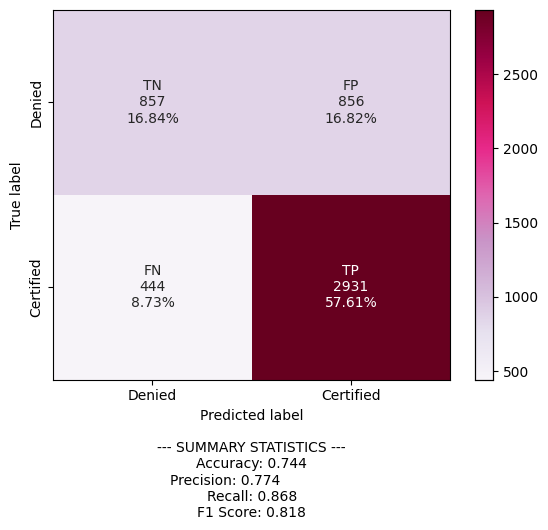

In [158]:
# Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
labels = ['TN','FP','FN','TP']
categories = ['Denied', 'Certified']
make_confusion_matrix(cf_matrix, group_names=labels, categories=categories, cmap='PuRd')

In [159]:
selected_best_model = {
    'Gradient Boosting': GradientBoostingClassifier(**models_param['Gradient Boosting'], random_state=SEED),
}

best_train_perf_report, best_val_perf_report = evaluate_models(X_train=X_full_train, y_train=y_full_train,
                                                               X_val=X_test, y_val=y_test,
                                                               models=selected_best_model)

##### Check model performance on train set

In [160]:
best_train_perf_report

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
0,Gradient Boosting,0.767446,0.793244,0.88269,0.83558,0.708368,0.778722


##### Check model performance on test set

In [161]:
best_val_perf_report

,Model Name,Accuracy,Precision,Recall,F1-score,AUROC,AUPRC
0,Gradient Boosting,0.744497,0.773964,0.868444,0.818486,0.684368,0.759409


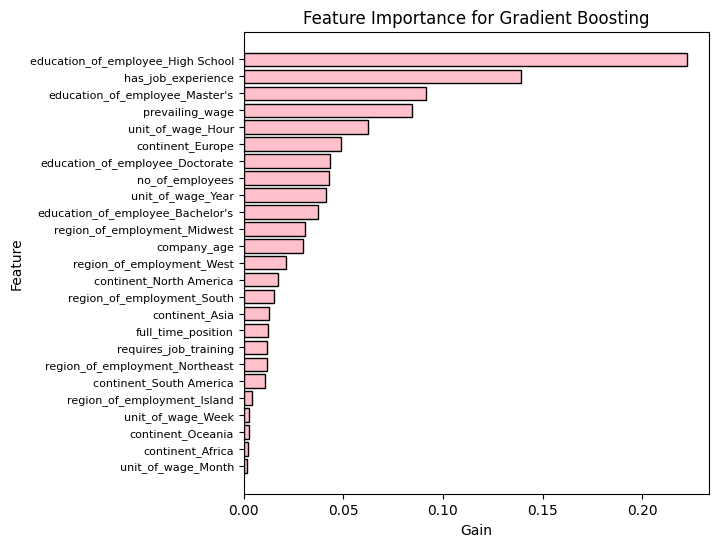

In [162]:
feature_names = [row.split('__')[1] for row in list(preprocessor.get_feature_names_out())]
importances = best_model.feature_importances_
indices = np.argsort(importances)

# Plot the bar graph for feature importance
plt.figure(figsize=(6, 6))

plt.title("Feature Importance for Gradient Boosting")
plt.barh(range(len(indices)), importances[indices], color='pink', edgecolor='black', align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=8)
plt.xlabel("Gain")
plt.ylabel('Feature')

plt.show()

Based on feature importance scores, the top-5 most important factors contributing to visa certification are:

1. **Employee Education:** Higher levels of education often indicate greater skills and qualifications, increasing the likelihood of visa approval.

2. **Prior Job Experience:** Relevant experience in the proposed field demonstrates expertise and increases the chances of successful visa application.

3. **Unit of Wage:** The specific unit of wage (e.g., hourly, weekly, monthly, yearly) can provide crucial insights into the nature of employment and significantly influence the prevailing wage determination, which ultimately impacts the likelihood of visa approval.

4. **Country of Origin:** The country of origin can influence visa approval rates due to factors such as immigration policies and economic relations between countries.

5. **Prevailing Wage:** A higher prevailing wage for the position suggests a higher demand for skilled workers and may increase the likelihood of visa approval.





#### Explainability with SHAP

SHapley Additive exPlanations (SHAP) is a model-agnostic technique that leverages Shapely values from game theory to quantify feature contributions to predictions. It helps explain the output of any machine learning model, making black box models (like neural networks or gradient boosting machines) more interpretable and trustworthy.

In [163]:
import shap

# Create a SHAP Explainer
explainer = shap.Explainer(best_model)

# Calculate SHAP values
X_full_train_df = pd.DataFrame(X_full_train, columns=feature_names)
shap_values = explainer(X_full_train_df)

np.shape(shap_values.values)

(20348, 25)

#### Absolute Mean SHAP

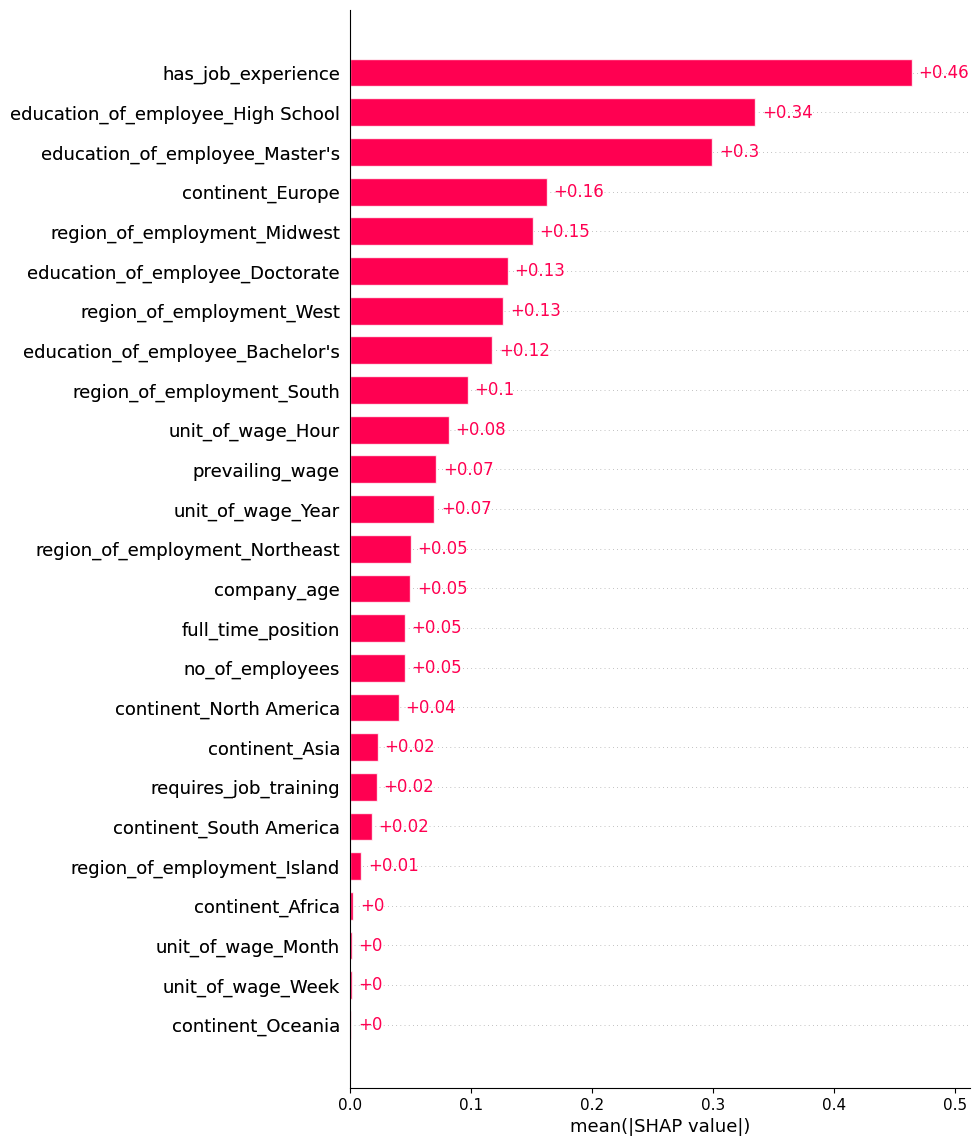

In [164]:
shap.plots.bar(shap_values, max_display=X_full_train_df.shape[1])

**Observations:**
- Having prior job experience significantly drives visa approval while weekly and monthly wage units have little to no bearing. 

#### Beeswarm plot

The beeswarm plot provides a granular view of SHAP value distributions, illustrating the direction and magnitude of each feature's impact on visa approval predictions across all observations. Positive SHAP values indicate an increased likelihood of a certified visa, while negative values indicate a decreased likelihood.

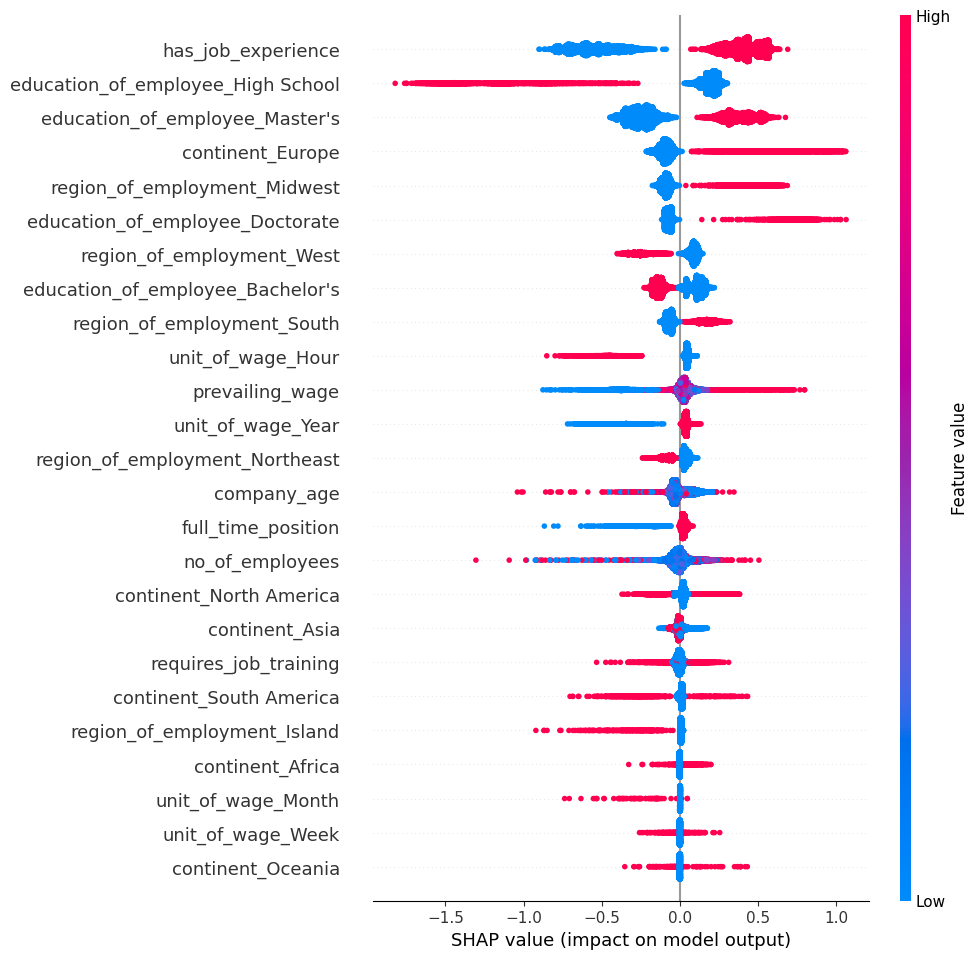

In [165]:
shap.plots.beeswarm(shap_values, max_display=X_full_train_df.shape[1])

#### Partial dependence plot

Let's generate partial dependence plots for some of these features and analyze what they reveal about the feature's impact on predictions.

- For each sample:
    - Vary value of selected feature
    - Hold other features constant
    - Predict outcome
- Average results from all samples

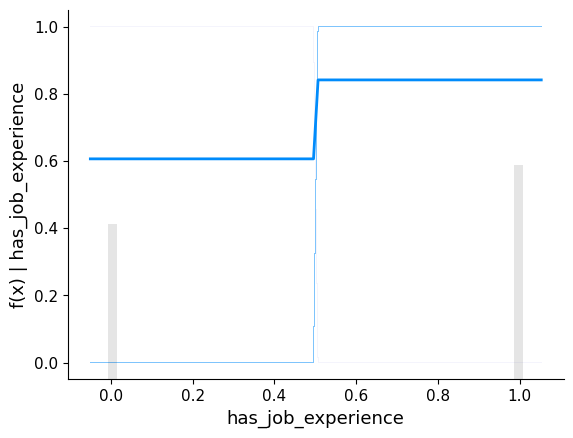

In [166]:
shap.partial_dependence_plot("has_job_experience", best_model.predict, X_full_train_df)

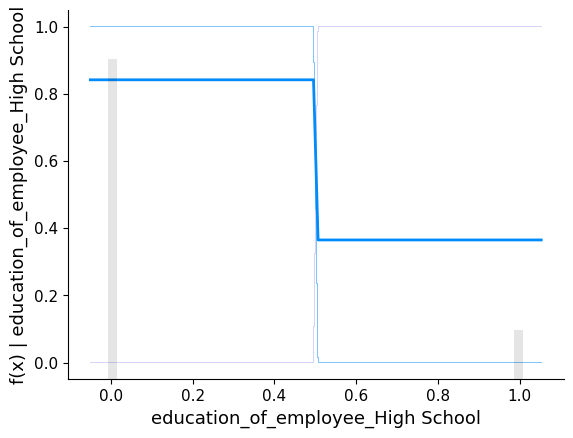

In [167]:
shap.partial_dependence_plot("education_of_employee_High School", best_model.predict, X_full_train_df)

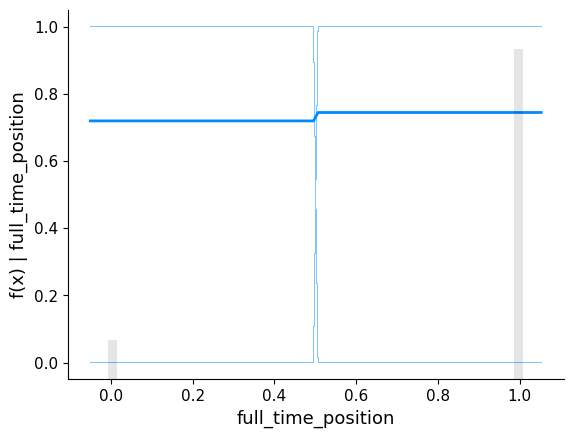

In [168]:
shap.partial_dependence_plot("full_time_position", best_model.predict, X_full_train_df)

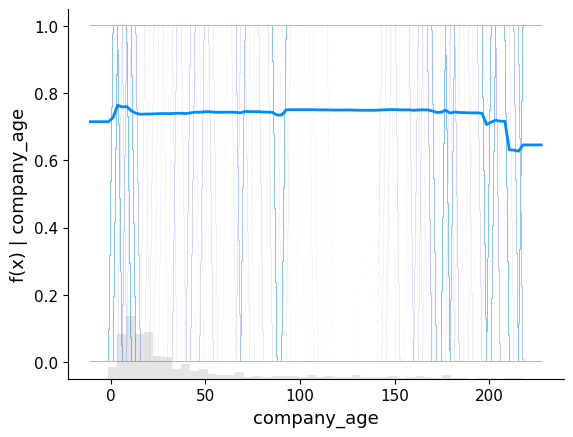

In [169]:
shap.partial_dependence_plot("company_age", best_model.predict, X_full_train_df)

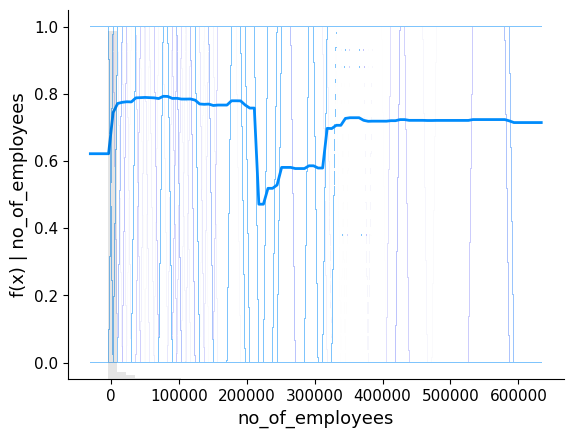

In [170]:
shap.partial_dependence_plot("no_of_employees", best_model.predict, X_full_train_df)

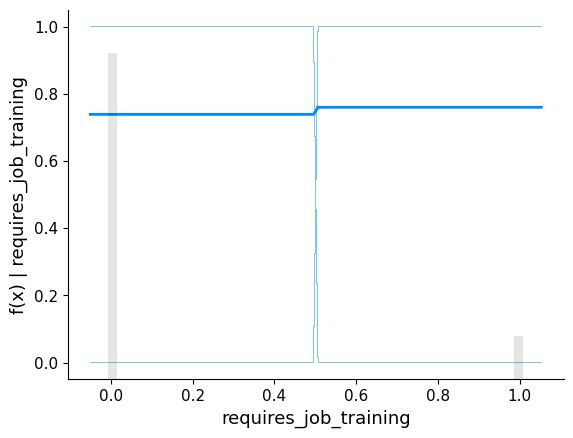

In [171]:
shap.partial_dependence_plot("requires_job_training", best_model.predict, X_full_train_df)

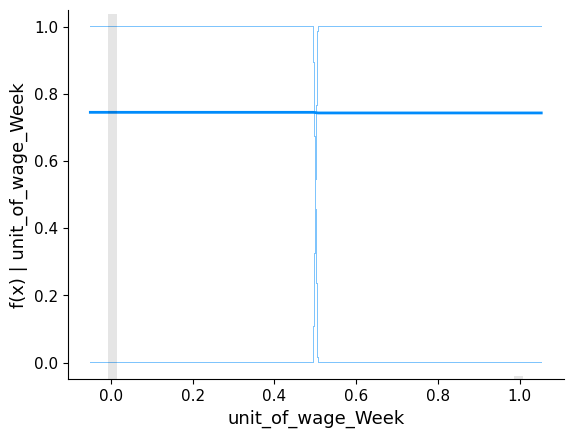

In [172]:
shap.partial_dependence_plot("unit_of_wage_Week", best_model.predict, X_full_train_df)

With the aid of these partial dependence plots, we can see how changes in these features affect the probability of visa approval, giving OFLC officers nuanced insights into their impact.

#### Waterfall plot

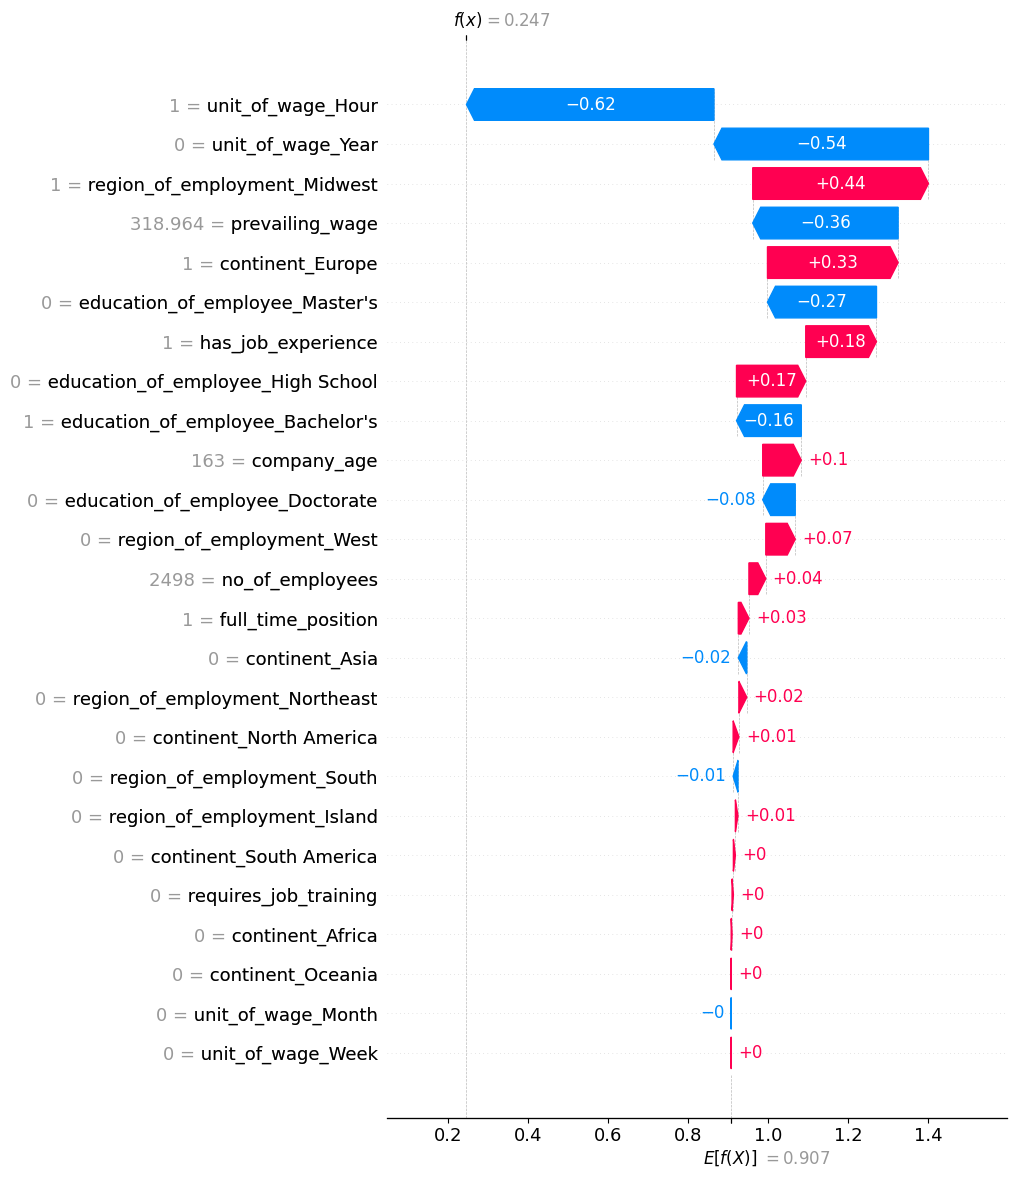

In [173]:
shap.plots.waterfall(shap_values[0], max_display=X_full_train_df.shape[1])

#### Stacked Force plot

In [179]:
shap.initjs()
shap.plots.force(shap_values[0:100])

## 7. Case Study Conclusion

#### Insights
- **Education and Experience Matter:** The feature importance analysis demonstrates that education level and having prior job experience are significant predictors of visa approval. This observation aligns with the policy objective of attracting qualified talent, as applicants with higher education and relevant experience are likely to possess the skills and qualifications necessary for successful employment in the United States.
- **Wage as an Indicator:** Prevailing wage, particularly for positions with hourly wages, emerged as a critical factor. A higher prevailing wage often indicates a greater demand for skilled labor, potentially increasing the likelihood of visa approval. This finding suggests that positions with higher wages may be considered more valuable to the U.S. economy.
- **Model Performance:** The tuned Gradient Boosting Classifier exhibited a balanced performance across key metrics, including accuracy, precision, recall, F1-score, AUROC, and AUPRC. This balanced performance suggests that the model is capable of making accurate predictions while maintaining a balance between correctly identifying certified and denied applications, which is crucial for a fair and effective decision-making process.

#### Recommendations
- **Prioritize High-Impact Applications:** Given the limited resources available, OFLC could prioritize reviewing applications with higher education levels, relevant prior job experience, and higher prevailing wages, as these applications are more likely to meet the criteria for approval and align with the policy goals of attracting skilled talent.
- **Decision Support Tool:** Implement the tuned Gradient Boosting Classifier as a decision support tool to assist OFLC officers in making more informed and data-driven decisions. It is crucial to emphasize that the model should serve as an aid to human decision-making and not replace the officer's professional judgment.
- **Continuous Monitoring and Improvement:** Regular monitoring of the model's performance and updates with new data are essential to ensure its continued relevance and accuracy. This includes periodically revisiting the feature importance analysis to adapt to changes in the labor market and immigration policies.
- **Transparency and Fairness:** Ensure that the use of the model is transparent and that it does not introduce bias against any specific group of applicants. Regular audits for fairness and bias are crucial to maintain trust and confidence in the visa approval process.